# Setup

In [ ]:
%load_ext autoreload
%autoreload 2
from bliss.encoders.deblend import GalaxyEncoder

import numpy as np
import matplotlib.pyplot as plt 
import torch
from astropy.table import Table
from bliss.datasets.table_utils import column_to_tensor

from astropy.table import Table
from bliss.datasets.lsst import get_default_lsst_psf, get_default_lsst_background
from bliss.datasets.background import add_noise_and_background


from einops import rearrange, pack, unpack, reduce



# dataset
from bliss.datasets.galsim_blends import generate_dataset, SavedGalsimBlends, parse_dataset


In [ ]:
!echo $CUDA_VISIBLE_DEVICES

5


# Quick look at dataset

In [ ]:
catsim_table = Table.read("../../../data/OneDegSq.fits")
cat = catsim_table[catsim_table["i_ab"] < 27.3]
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
star_mags = all_star_mags[all_star_mags > 20]
psf = get_default_lsst_psf()

n_samples = 50
dataset = generate_dataset(n_samples, cat, star_mags, psf, max_n_sources=10)

100%|██████████| 50/50 [00:03<00:00, 15.68it/s]


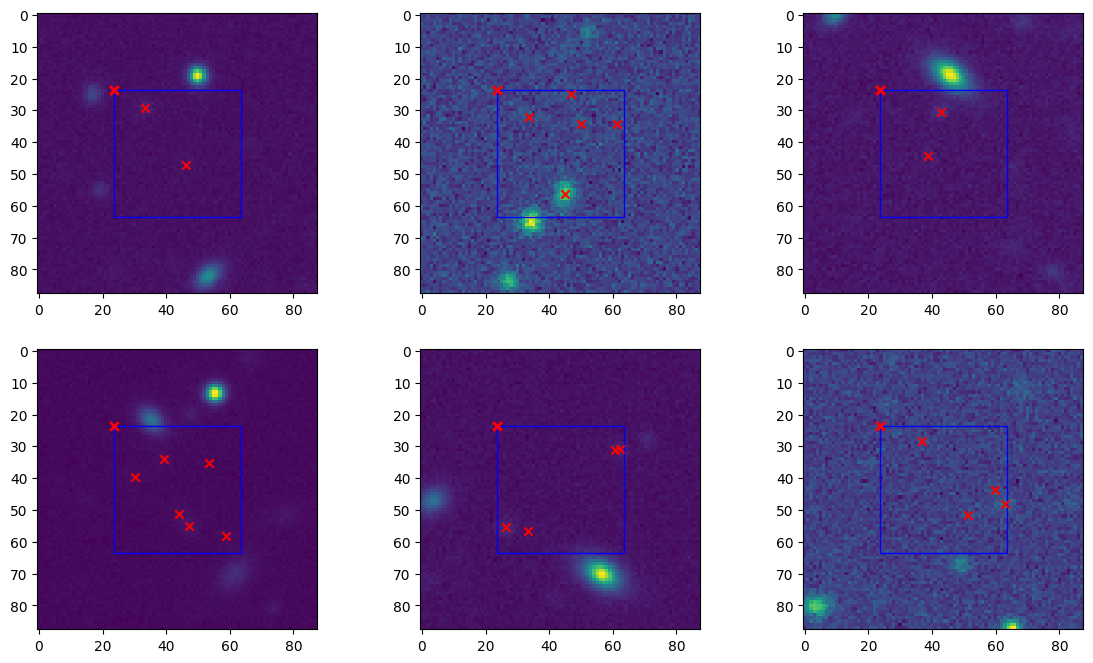

In [ ]:
import matplotlib.patches as patches

rand_indices = np.random.choice(range(n_samples), size=6, replace=False)
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    image = dataset['images'][idx][0]

    ax.imshow(np.log10(image), interpolation='none')

    # square of 8 pixels centered
    rect = patches.Rectangle((43.5-20, 43.5-20), 40, 40, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)


    plocs = dataset['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24

    # print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')
    


# Individual galaxies, onlybright, centered, one tile; check overfitting

In [ ]:
# smaller dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
cat = catsim_table[ (catsim_table["i_ab"] < 23) & (catsim_table["i_ab"] > 20)]
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
star_mags = all_star_mags[all_star_mags > 20]
psf = get_default_lsst_psf()

n_samples = 50
dataset = generate_dataset(n_samples, cat, star_mags, psf, slen=4, bp=24, max_n_sources=1,galaxy_density=1000000, star_density=0, max_shift=0.0, add_galaxies_in_padding=False)


100%|██████████| 50/50 [00:00<00:00, 135.14it/s]


ii tensor([0.5000, 0.5000])
ii tensor([0.5000, 0.5000])
ii tensor([0.5000, 0.5000])


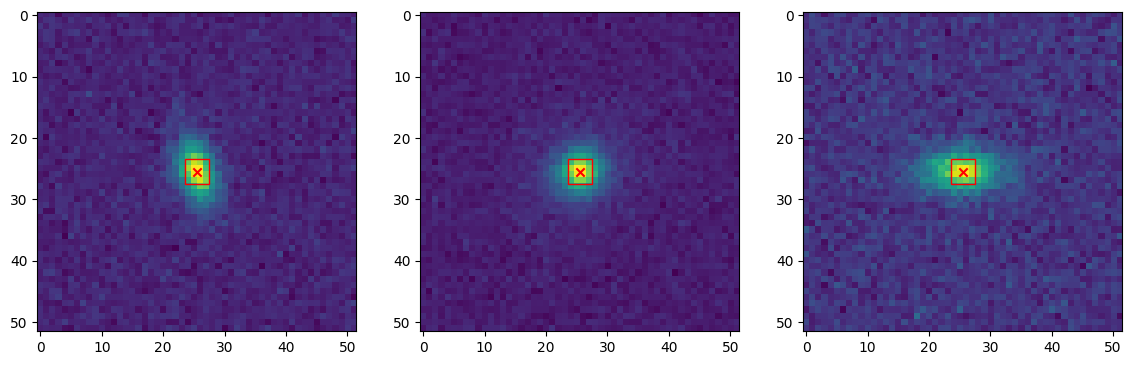

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs = dataset['plocs'][idx][0]
    y, x = plocs - 0.5 + 24
    print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# setup training datasets
# train, test split
train_idx = 40
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

# now save  data
torch.save(train_ds, "train_ds1.pt")
torch.save(val_ds, "val_ds1.pt")
# create datasets
train_dataset = SavedGalsimBlends("train_ds1.pt", 40, slen=4, keep_padding=True)
validation_dataset = SavedGalsimBlends("val_ds1.pt", 10, slen=4, keep_padding=True)
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=32)
# now train on the same batch 100 times with some optimizer 


In [ ]:

from torch.optim import Adam
from tqdm import tqdm
encoder = GalaxyEncoder('../models/autoencoder.pt')

# gpu 
gpu = torch.device("cuda:0")
encoder.to(gpu)

opt = Adam(encoder.parameters(), lr=1e-2)


for ii in tqdm(range(500), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat, paddings = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        paddings = paddings.to(gpu)
        loss = encoder.get_loss(images, paddings, background, truth_cat)
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        train_n_batches+=1 

    running_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   2%|▏         | 8/500 [00:00<00:15, 32.58it/s]

epoch: 4 ,training_loss:  811954.59375
epoch: 9 ,training_loss:  552173.015625


epoch::   4%|▍         | 20/500 [00:00<00:14, 32.40it/s]

epoch: 14 ,training_loss:  455299.515625
epoch: 19 ,training_loss:  453883.9296875


epoch::   6%|▌         | 28/500 [00:00<00:15, 31.44it/s]

epoch: 24 ,training_loss:  445001.015625
epoch: 29 ,training_loss:  438702.453125


epoch::   8%|▊         | 40/500 [00:01<00:15, 30.26it/s]

epoch: 34 ,training_loss:  434923.6796875
epoch: 39 ,training_loss:  431516.7578125


epoch::  10%|▉         | 48/500 [00:01<00:14, 30.26it/s]

epoch: 44 ,training_loss:  428574.1796875
epoch: 49 ,training_loss:  423140.59375


epoch::  12%|█▏        | 60/500 [00:01<00:14, 30.55it/s]

epoch: 54 ,training_loss:  417027.328125
epoch: 59 ,training_loss:  413476.40625


epoch::  14%|█▎        | 68/500 [00:02<00:14, 30.37it/s]

epoch: 64 ,training_loss:  411188.375
epoch: 69 ,training_loss:  410875.4140625


epoch::  16%|█▌        | 80/500 [00:02<00:13, 30.21it/s]

epoch: 74 ,training_loss:  409438.6640625
epoch: 79 ,training_loss:  409359.796875


epoch::  18%|█▊        | 88/500 [00:02<00:13, 29.96it/s]

epoch: 84 ,training_loss:  410767.953125
epoch: 89 ,training_loss:  408558.8046875


epoch::  20%|██        | 100/500 [00:03<00:13, 29.02it/s]

epoch: 94 ,training_loss:  407852.9609375
epoch: 99 ,training_loss:  407526.1328125


epoch::  22%|██▏       | 109/500 [00:03<00:13, 28.73it/s]

epoch: 104 ,training_loss:  407335.125
epoch: 109 ,training_loss:  407162.75


epoch::  24%|██▎       | 118/500 [00:03<00:13, 28.68it/s]

epoch: 114 ,training_loss:  406852.2265625
epoch: 119 ,training_loss:  406733.6171875


epoch::  26%|██▌       | 130/500 [00:04<00:12, 29.02it/s]

epoch: 124 ,training_loss:  406844.78125
epoch: 129 ,training_loss:  406745.65625


epoch::  28%|██▊       | 139/500 [00:04<00:12, 29.05it/s]

epoch: 134 ,training_loss:  407042.578125
epoch: 139 ,training_loss:  406743.7578125


epoch::  30%|██▉       | 148/500 [00:04<00:12, 28.64it/s]

epoch: 144 ,training_loss:  406383.7421875
epoch: 149 ,training_loss:  406225.6953125


epoch::  32%|███▏      | 160/500 [00:05<00:12, 28.10it/s]

epoch: 154 ,training_loss:  406189.234375
epoch: 159 ,training_loss:  406157.671875


epoch::  34%|███▍      | 169/500 [00:05<00:11, 27.96it/s]

epoch: 164 ,training_loss:  406140.8125
epoch: 169 ,training_loss:  406127.703125


epoch::  36%|███▌      | 178/500 [00:06<00:11, 28.16it/s]

epoch: 174 ,training_loss:  406182.7109375
epoch: 179 ,training_loss:  406183.4921875


epoch::  38%|███▊      | 190/500 [00:06<00:10, 28.76it/s]

epoch: 184 ,training_loss:  406241.2421875
epoch: 189 ,training_loss:  406569.3125


epoch::  40%|███▉      | 199/500 [00:06<00:10, 28.87it/s]

epoch: 194 ,training_loss:  406257.578125
epoch: 199 ,training_loss:  408946.78125


epoch::  42%|████▏     | 208/500 [00:07<00:10, 28.19it/s]

epoch: 204 ,training_loss:  407056.5
epoch: 209 ,training_loss:  407366.53125


epoch::  44%|████▍     | 220/500 [00:07<00:10, 27.97it/s]

epoch: 214 ,training_loss:  406215.96875
epoch: 219 ,training_loss:  406182.46875


epoch::  46%|████▌     | 229/500 [00:07<00:09, 28.27it/s]

epoch: 224 ,training_loss:  406034.265625
epoch: 229 ,training_loss:  406038.890625


epoch::  48%|████▊     | 238/500 [00:08<00:09, 28.39it/s]

epoch: 234 ,training_loss:  405991.015625
epoch: 239 ,training_loss:  405981.8046875


epoch::  50%|█████     | 250/500 [00:08<00:08, 28.20it/s]

epoch: 244 ,training_loss:  405972.25
epoch: 249 ,training_loss:  406022.734375


epoch::  52%|█████▏    | 259/500 [00:08<00:08, 28.02it/s]

epoch: 254 ,training_loss:  406068.9140625
epoch: 259 ,training_loss:  406009.671875


epoch::  54%|█████▎    | 268/500 [00:09<00:08, 27.71it/s]

epoch: 264 ,training_loss:  406113.6875
epoch: 269 ,training_loss:  407884.265625


epoch::  56%|█████▌    | 280/500 [00:09<00:07, 27.98it/s]

epoch: 274 ,training_loss:  406229.671875
epoch: 279 ,training_loss:  406378.8984375


epoch::  58%|█████▊    | 289/500 [00:09<00:07, 28.10it/s]

epoch: 284 ,training_loss:  406213.234375
epoch: 289 ,training_loss:  405954.59375


epoch::  60%|█████▉    | 298/500 [00:10<00:07, 28.24it/s]

epoch: 294 ,training_loss:  405947.28125
epoch: 299 ,training_loss:  406004.0390625


epoch::  62%|██████▏   | 310/500 [00:10<00:06, 28.49it/s]

epoch: 304 ,training_loss:  405994.8125
epoch: 309 ,training_loss:  406075.703125


epoch::  64%|██████▍   | 319/500 [00:11<00:06, 28.09it/s]

epoch: 314 ,training_loss:  409057.9609375
epoch: 319 ,training_loss:  408443.2734375


epoch::  66%|██████▌   | 328/500 [00:11<00:06, 27.87it/s]

epoch: 324 ,training_loss:  406715.1875
epoch: 329 ,training_loss:  406105.109375


epoch::  68%|██████▊   | 340/500 [00:11<00:05, 28.08it/s]

epoch: 334 ,training_loss:  406174.859375
epoch: 339 ,training_loss:  406127.3046875


epoch::  70%|██████▉   | 349/500 [00:12<00:05, 28.35it/s]

epoch: 344 ,training_loss:  406009.328125
epoch: 349 ,training_loss:  406015.484375


epoch::  72%|███████▏  | 358/500 [00:12<00:04, 28.50it/s]

epoch: 354 ,training_loss:  405914.609375
epoch: 359 ,training_loss:  406388.171875


epoch::  74%|███████▍  | 370/500 [00:12<00:04, 28.58it/s]

epoch: 364 ,training_loss:  407734.2734375
epoch: 369 ,training_loss:  407149.78125


epoch::  76%|███████▌  | 379/500 [00:13<00:04, 28.06it/s]

epoch: 374 ,training_loss:  406131.859375
epoch: 379 ,training_loss:  406042.9375


epoch::  78%|███████▊  | 388/500 [00:13<00:04, 27.87it/s]

epoch: 384 ,training_loss:  405922.171875
epoch: 389 ,training_loss:  406017.234375


epoch::  80%|████████  | 400/500 [00:13<00:03, 28.31it/s]

epoch: 394 ,training_loss:  408866.1875
epoch: 399 ,training_loss:  406289.5


epoch::  82%|████████▏ | 409/500 [00:14<00:03, 28.33it/s]

epoch: 404 ,training_loss:  406758.015625
epoch: 409 ,training_loss:  406045.921875


epoch::  84%|████████▎ | 418/500 [00:14<00:02, 28.09it/s]

epoch: 414 ,training_loss:  405917.0625
epoch: 419 ,training_loss:  406040.2109375


epoch::  86%|████████▌ | 430/500 [00:14<00:02, 28.08it/s]

epoch: 424 ,training_loss:  405892.9921875
epoch: 429 ,training_loss:  405917.7109375


epoch::  88%|████████▊ | 439/500 [00:15<00:02, 27.87it/s]

epoch: 434 ,training_loss:  405870.28125
epoch: 439 ,training_loss:  405865.7421875


epoch::  90%|████████▉ | 448/500 [00:15<00:01, 27.84it/s]

epoch: 444 ,training_loss:  405859.5546875
epoch: 449 ,training_loss:  406672.59375


epoch::  92%|█████████▏| 460/500 [00:16<00:01, 27.94it/s]

epoch: 454 ,training_loss:  407681.953125
epoch: 459 ,training_loss:  406059.84375


epoch::  94%|█████████▍| 469/500 [00:16<00:01, 28.28it/s]

epoch: 464 ,training_loss:  406088.0
epoch: 469 ,training_loss:  405932.8671875


epoch::  96%|█████████▌| 478/500 [00:16<00:00, 28.46it/s]

epoch: 474 ,training_loss:  406726.015625
epoch: 479 ,training_loss:  431260.0859375


epoch::  98%|█████████▊| 490/500 [00:17<00:00, 27.64it/s]

epoch: 484 ,training_loss:  416095.625
epoch: 489 ,training_loss:  411297.1328125


epoch:: 100%|██████████| 500/500 [00:17<00:00, 28.61it/s]

epoch: 494 ,training_loss:  408255.0390625
epoch: 499 ,training_loss:  406670.9921875


In [ ]:
# from torch import Tensor
# from bliss.render_tiles import render_galaxy_ptiles
# from bliss.datasets.lsst import get_default_lsst_psf_tensor
# from bliss.catalog import FullCatalog

# # look at some predictions!
# model_cpu = encoder.to(torch.device("cpu"))
# model_cpu.eval()

# true_images = []
# pred_images = [] 

# # save  images of residuals + flux scatter + ellipticity in a separate PDF
# with torch.no_grad():
#     for tbatch in train_dl:
#         images, background, truth_cat, padding = parse_dataset(tbatch)
#         galaxy_params_tiled = model_cpu.variational_mode(images, background, truth_cat)
#         galaxies = render_galaxy_ptiles(model_cpu._dec, truth_cat.locs, 
#                                         galaxy_params_tiled, truth_cat['galaxy_bools'], 
#                                         52, 4)
#         galaxies = galaxies.reshape(-1, 1, 52, 52) + background.mean()

#         true_images.append(images)
#         pred_images.append(galaxies)

# true_images, _ = pack(true_images, '* c h w')
# pred_images, _ = pack(pred_images, '* c h w')

In [ ]:
from torch import Tensor
from bliss.render_tiles import render_galaxy_ptiles
from bliss.datasets.lsst import get_default_lsst_psf_tensor
from bliss.catalog import FullCatalog

# look at some predictions!
model_cpu = encoder.to(torch.device("cpu"))
model_cpu.eval()


# let's run it on the entire training dataset
blend_data: dict[str, Tensor] = torch.load("train_ds1.pt")
images = blend_data.pop("images").float()
background = blend_data.pop("background").float()
individuals = blend_data.pop("individuals").float()
blend_data.pop("noiseless")
blend_data.pop("paddings")

n_batches, _, size, _ = images.shape
assert background.shape == images.shape

# get psf
psf_tensor = get_default_lsst_psf_tensor(size)

# obtain `FullCatalog` from saved data
slen = size - 2 * (model_cpu.bp)
full_cat = FullCatalog(slen, slen, blend_data)
truth_cat = full_cat.to_tile_params(4, ignore_extra_sources=True)

In [ ]:

# save  images of residuals + flux scatter + ellipticity in a separate PDF
with torch.no_grad():
    galaxy_params_tiled = model_cpu.variational_mode(images, background, truth_cat)
    galaxies = render_galaxy_ptiles(model_cpu._dec, truth_cat.locs, 
                                    galaxy_params_tiled, truth_cat['galaxy_bools'], 
                                    52, 4)
    pred_images = galaxies.reshape(-1, 1, 52, 52) + background.mean()




In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# compare both galaxies side by side
fig, axes = plt.subplots(20, 3, figsize=(8, 40))
for ii, (ax1, ax2, ax3) in enumerate(axes):
    im1 = ax1.imshow(images[ii, 0])
    im2 = ax2.imshow(pred_images[ii, 0])
    im3 = ax3.imshow( (pred_images[ii, 0] - images[ii, 0]) /  pred_images[ii,0].sqrt() )

    for im, ax in zip((im1,im2,im3), (ax1,ax2,ax3)):
        divider = make_axes_locatable(ax)
        cax =  divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
_ = fig.savefig('residuals1.pdf');
plt.close(fig)

In [ ]:
# now plot flux scatter and ellipticities
from bliss.reporting import get_single_galaxy_measurements
(flux1, snrs1, ellips1) = get_single_galaxy_measurements(individuals.reshape(-1, 1, 52, 52), 
                                              background.reshape(-1, 1, 52, 52), psf_tensor)
(flux2, snrs2, ellips2) = get_single_galaxy_measurements(galaxies.reshape(-1, 1, 52, 52), 
                                              background.reshape(-1, 1, 52, 52), psf_tensor)

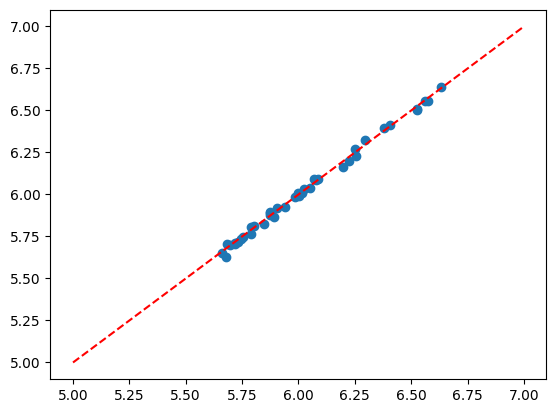

In [ ]:
plt.scatter(flux1.log10(), flux2.log10())
plt.plot([5, 7], [5, 7], linestyle='--', color='r')


In [ ]:
ellips1.shape

torch.Size([40, 2])

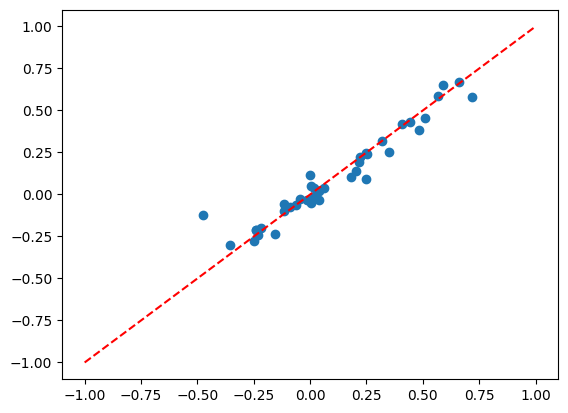

In [ ]:
plt.scatter(ellips1[:, 0], ellips2[:, 0])
plt.plot([-1, 1], [-1, 1], linestyle='--', color='r')


# Same as immediately above, but  galaxies is allowed to shift within 4x4 square in the middle

In [ ]:
# smaller dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
cat = catsim_table[ (catsim_table["i_ab"] < 23) & (catsim_table["i_ab"] > 20)]
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
star_mags = all_star_mags[all_star_mags > 20]
psf = get_default_lsst_psf()

n_samples = 50
dataset = generate_dataset(n_samples, cat, star_mags, psf, slen=4, bp=24, max_n_sources=1,galaxy_density=1000000, star_density=0, max_shift=0.5, add_galaxies_in_padding=False)


100%|██████████| 50/50 [00:00<00:00, 142.82it/s]


ii tensor([0.2934, 0.1978])
ii tensor([0.9838, 0.0671])
ii tensor([0.7639, 0.3395])


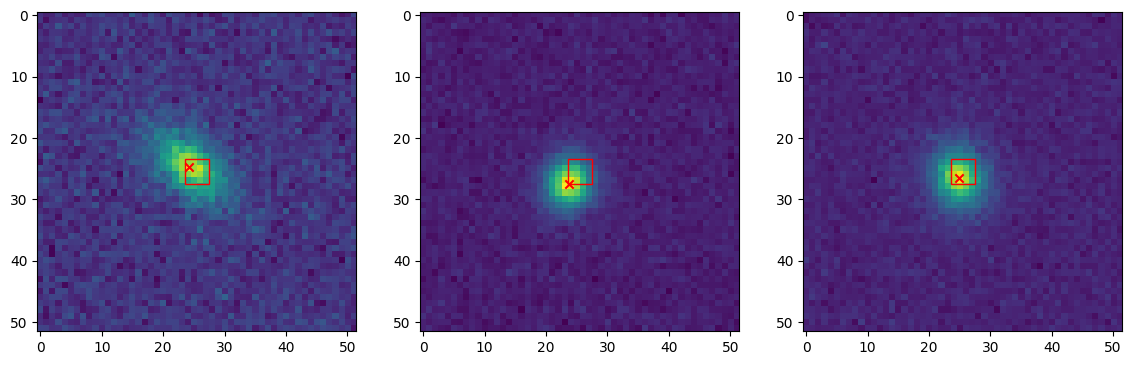

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    # square of 4 pixels centered
    rect = patches.Rectangle((25.5-2, 25.5-2), 4, 4, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)

    plocs = dataset['plocs'][idx][0]
    y, x = plocs - 0.5 + 24
    print('ii', plocs/4)

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# setup training datasets
# train, test split
train_idx = 40
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

# now save  data
torch.save(train_ds, "train_ds2.pt")
torch.save(val_ds, "val_ds2.pt")
# create datasets
train_dataset = SavedGalsimBlends("train_ds2.pt", 40, slen=4, keep_padding=True)
validation_dataset = SavedGalsimBlends("val_ds2.pt", 10, slen=4, keep_padding=True)
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=32)
# now train on the same batch 100 times with some optimizer 


In [ ]:

from torch.optim import Adam
from tqdm import tqdm
encoder = GalaxyEncoder('../models/autoencoder.pt')

# gpu 
gpu = torch.device("cuda:0")
encoder.to(gpu)

opt = Adam(encoder.parameters(), lr=1e-2)


for ii in tqdm(range(1000), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat, paddings = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        paddings = paddings.to(gpu)
        loss = encoder.get_loss(images, paddings, background, truth_cat)
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        train_n_batches+=1 

    running_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   1%|          | 8/1000 [00:00<00:29, 33.41it/s]

epoch: 4 ,training_loss:  652318.171875
epoch: 9 ,training_loss:  565632.28125


epoch::   2%|▏         | 20/1000 [00:00<00:30, 32.19it/s]

epoch: 14 ,training_loss:  466766.03125
epoch: 19 ,training_loss:  446518.2578125


epoch::   3%|▎         | 28/1000 [00:00<00:30, 31.66it/s]

epoch: 24 ,training_loss:  438648.578125
epoch: 29 ,training_loss:  429635.3671875


epoch::   4%|▍         | 40/1000 [00:01<00:30, 31.36it/s]

epoch: 34 ,training_loss:  450624.5234375
epoch: 39 ,training_loss:  425379.9921875


epoch::   5%|▍         | 48/1000 [00:01<00:30, 31.15it/s]

epoch: 44 ,training_loss:  424689.375
epoch: 49 ,training_loss:  420392.96875


epoch::   6%|▌         | 60/1000 [00:01<00:27, 33.83it/s]

epoch: 54 ,training_loss:  418413.3046875
epoch: 59 ,training_loss:  416204.671875


epoch::   7%|▋         | 68/1000 [00:02<00:27, 33.62it/s]

epoch: 64 ,training_loss:  414788.09375
epoch: 69 ,training_loss:  414038.890625


epoch::   8%|▊         | 80/1000 [00:02<00:28, 31.86it/s]

epoch: 74 ,training_loss:  413179.1015625
epoch: 79 ,training_loss:  412520.515625


epoch::   9%|▉         | 88/1000 [00:02<00:29, 31.28it/s]

epoch: 84 ,training_loss:  411717.5625
epoch: 89 ,training_loss:  411360.03125


epoch::  10%|█         | 100/1000 [00:03<00:28, 31.31it/s]

epoch: 94 ,training_loss:  409354.109375
epoch: 99 ,training_loss:  409003.5625


epoch::  11%|█         | 112/1000 [00:03<00:25, 34.18it/s]

epoch: 104 ,training_loss:  407492.546875
epoch: 109 ,training_loss:  407225.6640625


epoch::  12%|█▏        | 120/1000 [00:03<00:26, 33.77it/s]

epoch: 114 ,training_loss:  407312.484375
epoch: 119 ,training_loss:  406510.578125


epoch::  13%|█▎        | 128/1000 [00:03<00:26, 32.65it/s]

epoch: 124 ,training_loss:  406471.8203125
epoch: 129 ,training_loss:  406468.890625


epoch::  14%|█▍        | 140/1000 [00:04<00:27, 31.10it/s]

epoch: 134 ,training_loss:  406372.578125
epoch: 139 ,training_loss:  406892.078125


epoch::  15%|█▍        | 148/1000 [00:04<00:28, 30.34it/s]

epoch: 144 ,training_loss:  406364.3203125
epoch: 149 ,training_loss:  406368.328125


epoch::  16%|█▌        | 160/1000 [00:04<00:25, 33.37it/s]

epoch: 154 ,training_loss:  410341.140625
epoch: 159 ,training_loss:  411924.34375


epoch::  17%|█▋        | 168/1000 [00:05<00:25, 33.07it/s]

epoch: 164 ,training_loss:  407665.65625
epoch: 169 ,training_loss:  414024.4296875


epoch::  18%|█▊        | 180/1000 [00:05<00:25, 31.92it/s]

epoch: 174 ,training_loss:  408358.890625
epoch: 179 ,training_loss:  427187.28125


epoch::  19%|█▉        | 188/1000 [00:05<00:25, 31.66it/s]

epoch: 184 ,training_loss:  445676.265625
epoch: 189 ,training_loss:  416489.828125


epoch::  20%|██        | 200/1000 [00:06<00:25, 31.16it/s]

epoch: 194 ,training_loss:  410491.34375
epoch: 199 ,training_loss:  408321.953125


epoch::  21%|██        | 212/1000 [00:06<00:23, 33.74it/s]

epoch: 204 ,training_loss:  407681.4375
epoch: 209 ,training_loss:  406749.203125


epoch::  22%|██▏       | 220/1000 [00:06<00:23, 32.92it/s]

epoch: 214 ,training_loss:  406365.9609375
epoch: 219 ,training_loss:  406263.875


epoch::  23%|██▎       | 228/1000 [00:07<00:24, 32.00it/s]

epoch: 224 ,training_loss:  406229.6015625
epoch: 229 ,training_loss:  406209.0703125


epoch::  24%|██▍       | 240/1000 [00:07<00:24, 31.13it/s]

epoch: 234 ,training_loss:  406182.71875
epoch: 239 ,training_loss:  406169.15625


epoch::  25%|██▍       | 248/1000 [00:07<00:24, 30.72it/s]

epoch: 244 ,training_loss:  406152.546875
epoch: 249 ,training_loss:  406141.78125


epoch::  26%|██▌       | 260/1000 [00:08<00:22, 32.91it/s]

epoch: 254 ,training_loss:  406130.578125
epoch: 259 ,training_loss:  406120.65625


epoch::  27%|██▋       | 268/1000 [00:08<00:22, 32.58it/s]

epoch: 264 ,training_loss:  406110.53125
epoch: 269 ,training_loss:  406101.4453125


epoch::  28%|██▊       | 280/1000 [00:08<00:22, 31.46it/s]

epoch: 274 ,training_loss:  406093.15625
epoch: 279 ,training_loss:  406084.390625


epoch::  29%|██▉       | 288/1000 [00:08<00:22, 31.10it/s]

epoch: 284 ,training_loss:  406077.65625
epoch: 289 ,training_loss:  406070.109375


epoch::  30%|███       | 300/1000 [00:09<00:22, 30.81it/s]

epoch: 294 ,training_loss:  406063.234375
epoch: 299 ,training_loss:  406057.265625


epoch::  31%|███       | 312/1000 [00:09<00:20, 34.06it/s]

epoch: 304 ,training_loss:  406053.3125
epoch: 309 ,training_loss:  406046.96875


epoch::  32%|███▏      | 320/1000 [00:09<00:19, 34.07it/s]

epoch: 314 ,training_loss:  406041.71875
epoch: 319 ,training_loss:  406036.9375


epoch::  33%|███▎      | 328/1000 [00:10<00:20, 32.89it/s]

epoch: 324 ,training_loss:  406031.828125
epoch: 329 ,training_loss:  406026.2421875


epoch::  34%|███▍      | 340/1000 [00:10<00:20, 31.49it/s]

epoch: 334 ,training_loss:  406021.5859375
epoch: 339 ,training_loss:  406016.5


epoch::  35%|███▍      | 348/1000 [00:10<00:21, 31.04it/s]

epoch: 344 ,training_loss:  406011.625
epoch: 349 ,training_loss:  406006.78125


epoch::  36%|███▌      | 360/1000 [00:11<00:18, 34.22it/s]

epoch: 354 ,training_loss:  406003.0625
epoch: 359 ,training_loss:  406005.1171875


epoch::  37%|███▋      | 368/1000 [00:11<00:18, 34.46it/s]

epoch: 364 ,training_loss:  406001.4765625
epoch: 369 ,training_loss:  405999.3828125


epoch::  38%|███▊      | 380/1000 [00:11<00:18, 32.81it/s]

epoch: 374 ,training_loss:  405992.1953125
epoch: 379 ,training_loss:  405987.796875


epoch::  39%|███▉      | 388/1000 [00:12<00:18, 32.29it/s]

epoch: 384 ,training_loss:  405987.984375
epoch: 389 ,training_loss:  405989.4296875


epoch::  40%|████      | 400/1000 [00:12<00:19, 30.85it/s]

epoch: 394 ,training_loss:  405974.015625
epoch: 399 ,training_loss:  405969.4765625


epoch::  41%|████      | 412/1000 [00:12<00:17, 33.72it/s]

epoch: 404 ,training_loss:  405974.6015625
epoch: 409 ,training_loss:  405966.5390625


epoch::  42%|████▏     | 420/1000 [00:13<00:17, 33.17it/s]

epoch: 414 ,training_loss:  405964.234375
epoch: 419 ,training_loss:  405960.703125


epoch::  43%|████▎     | 428/1000 [00:13<00:17, 32.27it/s]

epoch: 424 ,training_loss:  405954.09375
epoch: 429 ,training_loss:  405950.328125


epoch::  44%|████▍     | 440/1000 [00:13<00:17, 31.49it/s]

epoch: 434 ,training_loss:  405948.7578125
epoch: 439 ,training_loss:  405950.03125


epoch::  45%|████▍     | 448/1000 [00:13<00:17, 31.02it/s]

epoch: 444 ,training_loss:  405992.390625
epoch: 449 ,training_loss:  406622.125


epoch::  46%|████▌     | 460/1000 [00:14<00:16, 32.76it/s]

epoch: 454 ,training_loss:  406129.0078125
epoch: 459 ,training_loss:  406383.921875


epoch::  47%|████▋     | 468/1000 [00:14<00:16, 32.85it/s]

epoch: 464 ,training_loss:  406097.4296875
epoch: 469 ,training_loss:  407118.6015625


epoch::  48%|████▊     | 480/1000 [00:14<00:16, 31.59it/s]

epoch: 474 ,training_loss:  410150.75
epoch: 479 ,training_loss:  408314.84375


epoch::  49%|████▉     | 488/1000 [00:15<00:16, 31.23it/s]

epoch: 484 ,training_loss:  408432.703125
epoch: 489 ,training_loss:  406599.59375


epoch::  50%|█████     | 500/1000 [00:15<00:16, 30.76it/s]

epoch: 494 ,training_loss:  406063.2734375
epoch: 499 ,training_loss:  406057.78125


epoch::  51%|█████     | 512/1000 [00:15<00:14, 34.01it/s]

epoch: 504 ,training_loss:  405964.5625
epoch: 509 ,training_loss:  405943.65625


epoch::  52%|█████▏    | 520/1000 [00:16<00:14, 33.68it/s]

epoch: 514 ,training_loss:  405938.890625
epoch: 519 ,training_loss:  405928.265625


epoch::  53%|█████▎    | 528/1000 [00:16<00:14, 32.12it/s]

epoch: 524 ,training_loss:  405920.3203125
epoch: 529 ,training_loss:  405920.28125


epoch::  54%|█████▍    | 540/1000 [00:16<00:14, 31.61it/s]

epoch: 534 ,training_loss:  405961.828125
epoch: 539 ,training_loss:  406259.828125


epoch::  55%|█████▍    | 548/1000 [00:17<00:14, 31.22it/s]

epoch: 544 ,training_loss:  406073.96875
epoch: 549 ,training_loss:  408018.078125


epoch::  56%|█████▌    | 560/1000 [00:17<00:13, 33.82it/s]

epoch: 554 ,training_loss:  406062.375
epoch: 559 ,training_loss:  406238.453125


epoch::  57%|█████▋    | 568/1000 [00:17<00:12, 34.18it/s]

epoch: 564 ,training_loss:  409516.0546875
epoch: 569 ,training_loss:  408528.2734375


epoch::  58%|█████▊    | 580/1000 [00:18<00:12, 32.73it/s]

epoch: 574 ,training_loss:  408109.140625
epoch: 579 ,training_loss:  408907.140625


epoch::  59%|█████▉    | 588/1000 [00:18<00:12, 31.88it/s]

epoch: 584 ,training_loss:  408308.7734375
epoch: 589 ,training_loss:  424127.8984375


epoch::  60%|██████    | 600/1000 [00:18<00:12, 32.73it/s]

epoch: 594 ,training_loss:  671788.40625
epoch: 599 ,training_loss:  476328.671875


epoch::  61%|██████    | 608/1000 [00:18<00:11, 33.23it/s]

epoch: 604 ,training_loss:  506113.890625
epoch: 609 ,training_loss:  424504.953125


epoch::  62%|██████▏   | 621/1000 [00:19<00:10, 35.12it/s]

epoch: 614 ,training_loss:  422521.484375
epoch: 619 ,training_loss:  415943.578125


epoch::  63%|██████▎   | 629/1000 [00:19<00:10, 33.96it/s]

epoch: 624 ,training_loss:  409909.515625
epoch: 629 ,training_loss:  408744.7578125


epoch::  64%|██████▍   | 641/1000 [00:19<00:11, 32.56it/s]

epoch: 634 ,training_loss:  407919.6484375
epoch: 639 ,training_loss:  407368.21875


epoch::  65%|██████▍   | 649/1000 [00:20<00:11, 31.83it/s]

epoch: 644 ,training_loss:  407123.28125
epoch: 649 ,training_loss:  406913.484375


epoch::  66%|██████▌   | 661/1000 [00:20<00:10, 32.73it/s]

epoch: 654 ,training_loss:  406773.34375
epoch: 659 ,training_loss:  406680.46875


epoch::  67%|██████▋   | 669/1000 [00:20<00:09, 34.18it/s]

epoch: 664 ,training_loss:  406609.0234375
epoch: 669 ,training_loss:  406552.578125


epoch::  68%|██████▊   | 681/1000 [00:21<00:09, 32.76it/s]

epoch: 674 ,training_loss:  406504.171875
epoch: 679 ,training_loss:  406459.28125


epoch::  69%|██████▉   | 689/1000 [00:21<00:09, 31.78it/s]

epoch: 684 ,training_loss:  406423.2890625
epoch: 689 ,training_loss:  406394.09375


epoch::  70%|███████   | 701/1000 [00:21<00:09, 31.18it/s]

epoch: 694 ,training_loss:  406368.765625
epoch: 699 ,training_loss:  406345.90625


epoch::  71%|███████   | 709/1000 [00:21<00:09, 31.21it/s]

epoch: 704 ,training_loss:  406325.140625
epoch: 709 ,training_loss:  406305.671875


epoch::  72%|███████▏  | 721/1000 [00:22<00:08, 33.48it/s]

epoch: 714 ,training_loss:  406289.09375
epoch: 719 ,training_loss:  406273.6875


epoch::  73%|███████▎  | 729/1000 [00:22<00:08, 32.93it/s]

epoch: 724 ,training_loss:  406259.109375
epoch: 729 ,training_loss:  406246.6953125


epoch::  74%|███████▍  | 741/1000 [00:22<00:08, 31.91it/s]

epoch: 734 ,training_loss:  406234.6015625
epoch: 739 ,training_loss:  406221.6171875


epoch::  75%|███████▍  | 749/1000 [00:23<00:07, 31.44it/s]

epoch: 744 ,training_loss:  406209.71875
epoch: 749 ,training_loss:  406196.953125


epoch::  76%|███████▌  | 761/1000 [00:23<00:07, 32.40it/s]

epoch: 754 ,training_loss:  406185.21875
epoch: 759 ,training_loss:  406174.109375


epoch::  77%|███████▋  | 769/1000 [00:23<00:06, 34.32it/s]

epoch: 764 ,training_loss:  406162.671875
epoch: 769 ,training_loss:  406149.9453125


epoch::  78%|███████▊  | 781/1000 [00:24<00:06, 32.83it/s]

epoch: 774 ,training_loss:  406138.65625
epoch: 779 ,training_loss:  406128.578125


epoch::  79%|███████▉  | 789/1000 [00:24<00:06, 31.61it/s]

epoch: 784 ,training_loss:  406116.890625
epoch: 789 ,training_loss:  406105.171875


epoch::  80%|████████  | 801/1000 [00:24<00:06, 31.05it/s]

epoch: 794 ,training_loss:  406090.515625
epoch: 799 ,training_loss:  406075.46875


epoch::  81%|████████  | 809/1000 [00:25<00:06, 31.22it/s]

epoch: 804 ,training_loss:  406059.671875
epoch: 809 ,training_loss:  406047.484375


epoch::  82%|████████▏ | 821/1000 [00:25<00:05, 34.75it/s]

epoch: 814 ,training_loss:  406037.6484375
epoch: 819 ,training_loss:  406030.09375


epoch::  83%|████████▎ | 829/1000 [00:25<00:04, 34.62it/s]

epoch: 824 ,training_loss:  406024.390625
epoch: 829 ,training_loss:  406018.078125


epoch::  84%|████████▍ | 841/1000 [00:25<00:04, 33.33it/s]

epoch: 834 ,training_loss:  406013.46875
epoch: 839 ,training_loss:  406008.3359375


epoch::  85%|████████▍ | 849/1000 [00:26<00:04, 32.49it/s]

epoch: 844 ,training_loss:  406004.6328125
epoch: 849 ,training_loss:  406000.671875


epoch::  86%|████████▌ | 861/1000 [00:26<00:04, 31.48it/s]

epoch: 854 ,training_loss:  405997.3046875
epoch: 859 ,training_loss:  405993.0703125


epoch::  87%|████████▋ | 869/1000 [00:26<00:03, 34.67it/s]

epoch: 864 ,training_loss:  405987.875
epoch: 869 ,training_loss:  405983.53125


epoch::  88%|████████▊ | 881/1000 [00:27<00:03, 33.55it/s]

epoch: 874 ,training_loss:  405973.65625
epoch: 879 ,training_loss:  405967.5546875


epoch::  89%|████████▉ | 889/1000 [00:27<00:03, 32.79it/s]

epoch: 884 ,training_loss:  405962.78125
epoch: 889 ,training_loss:  405956.046875


epoch::  90%|█████████ | 901/1000 [00:27<00:03, 32.12it/s]

epoch: 894 ,training_loss:  405953.4453125
epoch: 899 ,training_loss:  405948.53125


epoch::  91%|█████████ | 909/1000 [00:28<00:02, 31.25it/s]

epoch: 904 ,training_loss:  405948.015625
epoch: 909 ,training_loss:  405948.34375


epoch::  92%|█████████▏| 921/1000 [00:28<00:02, 33.21it/s]

epoch: 914 ,training_loss:  405946.140625
epoch: 919 ,training_loss:  405942.7734375


epoch::  93%|█████████▎| 929/1000 [00:28<00:02, 32.36it/s]

epoch: 924 ,training_loss:  405940.65625
epoch: 929 ,training_loss:  405937.609375


epoch::  94%|█████████▍| 941/1000 [00:29<00:01, 31.03it/s]

epoch: 934 ,training_loss:  405934.859375
epoch: 939 ,training_loss:  405937.421875


epoch::  95%|█████████▍| 949/1000 [00:29<00:01, 30.51it/s]

epoch: 944 ,training_loss:  405931.3515625
epoch: 949 ,training_loss:  405944.3046875


epoch::  96%|█████████▌| 961/1000 [00:29<00:01, 30.44it/s]

epoch: 954 ,training_loss:  405930.578125
epoch: 959 ,training_loss:  405927.7421875


epoch::  97%|█████████▋| 969/1000 [00:29<00:00, 33.38it/s]

epoch: 964 ,training_loss:  405927.625
epoch: 969 ,training_loss:  405931.6875


epoch::  98%|█████████▊| 981/1000 [00:30<00:00, 32.94it/s]

epoch: 974 ,training_loss:  405923.984375
epoch: 979 ,training_loss:  405928.703125


epoch::  99%|█████████▉| 989/1000 [00:30<00:00, 31.69it/s]

epoch: 984 ,training_loss:  405922.28125
epoch: 989 ,training_loss:  405929.4296875


epoch:: 100%|██████████| 1000/1000 [00:30<00:00, 32.31it/s]

epoch: 994 ,training_loss:  405934.6328125
epoch: 999 ,training_loss:  405939.3984375


In [ ]:
from torch import Tensor
from bliss.render_tiles import render_galaxy_ptiles, reconstruct_image_from_ptiles
from bliss.datasets.lsst import get_default_lsst_psf_tensor
from bliss.catalog import FullCatalog

# look at some predictions!
model_cpu = encoder.to(torch.device("cpu"))
model_cpu.eval()


# let's run it on the entire training dataset
blend_data: dict[str, Tensor] = torch.load("train_ds2.pt")
images = blend_data.pop("images").float()
background = blend_data.pop("background").float()
individuals = blend_data.pop("individuals").float()
blend_data.pop("noiseless")
blend_data.pop("paddings")

n_batches, _, size, _ = images.shape
assert background.shape == images.shape

# get psf
psf_tensor = get_default_lsst_psf_tensor(size)

# obtain `FullCatalog` from saved data
slen = size - 2 * (model_cpu.bp)
full_cat = FullCatalog(slen, slen, blend_data)
truth_cat = full_cat.to_tile_params(4, ignore_extra_sources=True)

In [ ]:

# save  images of residuals + flux scatter + ellipticity in a separate PDF
with torch.no_grad():
    galaxy_params_tiled = model_cpu.variational_mode(images, background, truth_cat)
    galaxies = render_galaxy_ptiles(model_cpu._dec, truth_cat.locs, 
                                    galaxy_params_tiled, truth_cat['galaxy_bools'], 
                                    52, 4)
    pred_images = galaxies.reshape(-1, 1, 52, 52) + background.mean()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# compare both galaxies side by side
fig, axes = plt.subplots(20, 3, figsize=(8, 40))
for ii, (ax1, ax2, ax3) in enumerate(axes):
    im1 = ax1.imshow(images[ii, 0])
    im2 = ax2.imshow(pred_images[ii, 0])
    im3 = ax3.imshow( (pred_images[ii, 0] - images[ii, 0]) /  pred_images[ii,0].sqrt() )

    for im, ax in zip((im1,im2,im3), (ax1,ax2,ax3)):
        divider = make_axes_locatable(ax)
        cax =  divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
_ = fig.savefig('residuals2.pdf');
plt.close(fig)

In [ ]:
# now plot flux scatter and ellipticities
from bliss.reporting import get_single_galaxy_measurements
(flux1, snrs1, ellips1) = get_single_galaxy_measurements(individuals.reshape(-1, 1, 52, 52), 
                                              background.reshape(-1, 1, 52, 52), psf_tensor)
(flux2, snrs2, ellips2) = get_single_galaxy_measurements(galaxies.reshape(-1, 1, 52, 52), 
                                              background.reshape(-1, 1, 52, 52), psf_tensor)

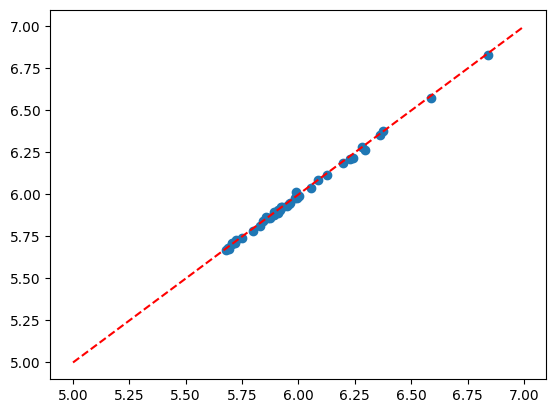

In [ ]:
plt.scatter(flux1.log10(), flux2.log10())
plt.plot([5, 7], [5, 7], linestyle='--', color='r')


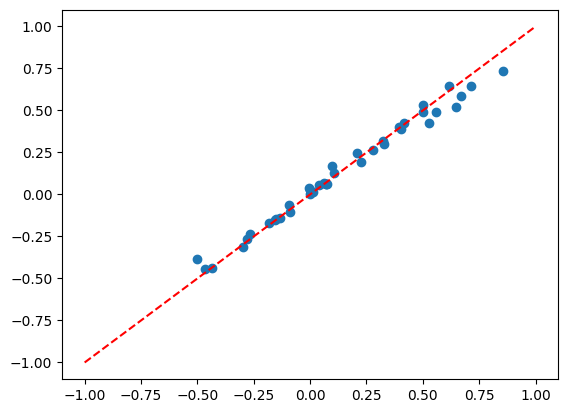

In [ ]:
plt.scatter(ellips1[:, 0], ellips2[:, 0])
plt.plot([-1, 1], [-1, 1], linestyle='--', color='r')


# 4 tiles, moving single galaxy, no padding, only bright

In [ ]:
# smaller dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
cat = catsim_table[ (catsim_table["i_ab"] < 23) & (catsim_table["i_ab"] > 20)]
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
star_mags = all_star_mags[all_star_mags > 20]
psf = get_default_lsst_psf()

n_samples = 50
dataset = generate_dataset(n_samples, cat, star_mags, psf, slen=8, bp=24, max_n_sources=1,galaxy_density=100000, star_density=0, max_shift=0.5, add_galaxies_in_padding=False)


100%|██████████| 50/50 [00:00<00:00, 134.60it/s]


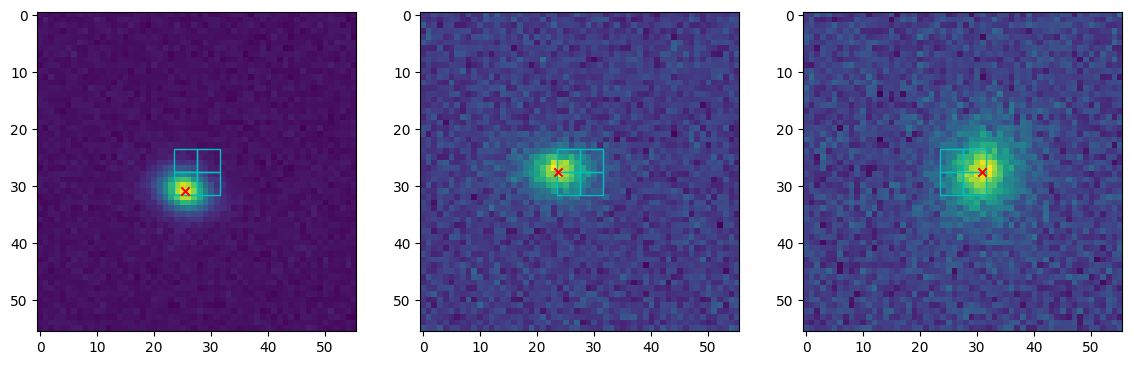

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    # plot the 4 tiles
    for ii in range(2):
        for jj in range(2):
            rect = patches.Rectangle((27.5-4+ii*4, 27.5-4+jj*4), 4, 4, linewidth=1, edgecolor='c', facecolor='none')
            ax.add_patch(rect)


    plocs = dataset['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# setup training datasets
# train, test split
train_idx = 40
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

# now save  data
torch.save(train_ds, "train_ds3.pt")
torch.save(val_ds, "val_ds3.pt")
# create datasets
train_dataset = SavedGalsimBlends("train_ds3.pt", 40, slen=8, keep_padding=True)
validation_dataset = SavedGalsimBlends("val_ds3.pt", 10, slen=8, keep_padding=True)
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 40, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=10)
# now train on the same batch 100 times with some optimizer 


In [ ]:

from torch.optim import Adam
from tqdm import tqdm
encoder = GalaxyEncoder('../models/autoencoder.pt')

# gpu 
gpu = torch.device("cuda:0")
encoder.to(gpu)

opt = Adam(encoder.parameters(), lr=1e-2)


for ii in tqdm(range(1000), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat, paddings = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        paddings = paddings.to(gpu)
        loss = encoder.get_loss(images, paddings, background, truth_cat)
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        train_n_batches+=1 

    running_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   1%|          | 11/1000 [00:01<01:23, 11.86it/s]

epoch: 4 ,training_loss:  1439585.625
epoch: 9 ,training_loss:  1621840.0


epoch::   2%|▏         | 23/1000 [00:01<00:38, 25.69it/s]

epoch: 14 ,training_loss:  1242482.875
epoch: 19 ,training_loss:  1244983.0
epoch: 24 ,training_loss:  1173870.625


epoch::   4%|▍         | 38/1000 [00:01<00:25, 37.30it/s]

epoch: 29 ,training_loss:  1122974.125
epoch: 34 ,training_loss:  1058031.625


epoch::   5%|▍         | 48/1000 [00:02<00:23, 41.15it/s]

epoch: 39 ,training_loss:  1033733.75
epoch: 44 ,training_loss:  1020208.8125


epoch::   6%|▌         | 58/1000 [00:02<00:22, 42.37it/s]

epoch: 49 ,training_loss:  1013700.5625
epoch: 54 ,training_loss:  1006660.25


epoch::   7%|▋         | 68/1000 [00:02<00:21, 43.40it/s]

epoch: 59 ,training_loss:  1001928.4375
epoch: 64 ,training_loss:  998221.875


epoch::   8%|▊         | 78/1000 [00:02<00:21, 43.69it/s]

epoch: 69 ,training_loss:  994069.875
epoch: 74 ,training_loss:  990530.9375


epoch::   9%|▉         | 88/1000 [00:03<00:20, 44.23it/s]

epoch: 79 ,training_loss:  987499.0
epoch: 84 ,training_loss:  978480.5


epoch::  10%|▉         | 98/1000 [00:03<00:20, 43.95it/s]

epoch: 89 ,training_loss:  973972.1875
epoch: 94 ,training_loss:  969247.875


epoch::  11%|█         | 108/1000 [00:03<00:20, 44.02it/s]

epoch: 99 ,training_loss:  966282.3125
epoch: 104 ,training_loss:  963528.3125


epoch::  12%|█▏        | 118/1000 [00:03<00:20, 43.99it/s]

epoch: 109 ,training_loss:  962997.3125
epoch: 114 ,training_loss:  960682.625


epoch::  13%|█▎        | 128/1000 [00:03<00:20, 43.22it/s]

epoch: 119 ,training_loss:  957486.0625
epoch: 124 ,training_loss:  956562.0625


epoch::  14%|█▍        | 138/1000 [00:04<00:19, 43.61it/s]

epoch: 129 ,training_loss:  954366.0
epoch: 134 ,training_loss:  952868.3125


epoch::  15%|█▍        | 148/1000 [00:04<00:19, 43.75it/s]

epoch: 139 ,training_loss:  951004.8125
epoch: 144 ,training_loss:  950761.125


epoch::  16%|█▌        | 158/1000 [00:04<00:19, 43.77it/s]

epoch: 149 ,training_loss:  949610.4375
epoch: 154 ,training_loss:  952727.25


epoch::  17%|█▋        | 168/1000 [00:04<00:18, 43.93it/s]

epoch: 159 ,training_loss:  948790.9375
epoch: 164 ,training_loss:  948611.125


epoch::  18%|█▊        | 178/1000 [00:05<00:18, 43.51it/s]

epoch: 169 ,training_loss:  948133.125
epoch: 174 ,training_loss:  946880.75


epoch::  19%|█▉        | 188/1000 [00:05<00:18, 44.10it/s]

epoch: 179 ,training_loss:  946336.8125
epoch: 184 ,training_loss:  945968.3125


epoch::  20%|█▉        | 198/1000 [00:05<00:18, 44.18it/s]

epoch: 189 ,training_loss:  945940.5
epoch: 194 ,training_loss:  946281.375


epoch::  21%|██        | 208/1000 [00:05<00:17, 44.32it/s]

epoch: 199 ,training_loss:  948666.4375
epoch: 204 ,training_loss:  946366.75


epoch::  22%|██▏       | 218/1000 [00:06<00:17, 44.05it/s]

epoch: 209 ,training_loss:  945933.625
epoch: 214 ,training_loss:  945463.9375


epoch::  23%|██▎       | 228/1000 [00:06<00:17, 44.17it/s]

epoch: 219 ,training_loss:  944987.875
epoch: 224 ,training_loss:  944726.5


epoch::  24%|██▍       | 238/1000 [00:06<00:17, 44.20it/s]

epoch: 229 ,training_loss:  944927.875
epoch: 234 ,training_loss:  944585.875


epoch::  25%|██▍       | 248/1000 [00:06<00:16, 44.24it/s]

epoch: 239 ,training_loss:  944397.375
epoch: 244 ,training_loss:  944306.9375


epoch::  26%|██▌       | 258/1000 [00:06<00:16, 44.57it/s]

epoch: 249 ,training_loss:  944397.3125
epoch: 254 ,training_loss:  944245.25


epoch::  27%|██▋       | 268/1000 [00:07<00:16, 43.75it/s]

epoch: 259 ,training_loss:  944240.25
epoch: 264 ,training_loss:  944671.3125


epoch::  28%|██▊       | 278/1000 [00:07<00:16, 43.35it/s]

epoch: 269 ,training_loss:  944151.375
epoch: 274 ,training_loss:  944015.9375


epoch::  29%|██▉       | 288/1000 [00:07<00:16, 43.99it/s]

epoch: 279 ,training_loss:  944068.0625
epoch: 284 ,training_loss:  944119.625


epoch::  30%|██▉       | 298/1000 [00:07<00:15, 44.10it/s]

epoch: 289 ,training_loss:  943926.8125
epoch: 294 ,training_loss:  943847.875


epoch::  31%|███       | 308/1000 [00:08<00:15, 44.14it/s]

epoch: 299 ,training_loss:  943801.5
epoch: 304 ,training_loss:  943781.625


epoch::  32%|███▏      | 318/1000 [00:08<00:15, 44.63it/s]

epoch: 309 ,training_loss:  943761.6875
epoch: 314 ,training_loss:  943739.3125


epoch::  33%|███▎      | 328/1000 [00:08<00:15, 44.53it/s]

epoch: 319 ,training_loss:  943717.75
epoch: 324 ,training_loss:  943704.5


epoch::  34%|███▍      | 338/1000 [00:08<00:14, 44.71it/s]

epoch: 329 ,training_loss:  943711.6875
epoch: 334 ,training_loss:  943672.75


epoch::  35%|███▍      | 348/1000 [00:08<00:14, 43.92it/s]

epoch: 339 ,training_loss:  943664.5
epoch: 344 ,training_loss:  943648.125


epoch::  35%|███▌      | 353/1000 [00:09<00:15, 41.74it/s]

epoch: 349 ,training_loss:  943631.5625
epoch: 354 ,training_loss:  943674.25


epoch::  37%|███▋      | 368/1000 [00:09<00:14, 42.69it/s]

epoch: 359 ,training_loss:  944250.625
epoch: 364 ,training_loss:  944223.25


epoch::  38%|███▊      | 378/1000 [00:09<00:14, 43.43it/s]

epoch: 369 ,training_loss:  944511.125
epoch: 374 ,training_loss:  944382.125


epoch::  39%|███▉      | 388/1000 [00:09<00:13, 43.75it/s]

epoch: 379 ,training_loss:  944517.5
epoch: 384 ,training_loss:  945312.4375


epoch::  40%|███▉      | 398/1000 [00:10<00:13, 43.90it/s]

epoch: 389 ,training_loss:  945403.375
epoch: 394 ,training_loss:  946244.625


epoch::  41%|████      | 408/1000 [00:10<00:13, 43.27it/s]

epoch: 399 ,training_loss:  944925.3125
epoch: 404 ,training_loss:  945814.125


epoch::  42%|████▏     | 418/1000 [00:10<00:13, 43.64it/s]

epoch: 409 ,training_loss:  945317.875
epoch: 414 ,training_loss:  944732.5


epoch::  43%|████▎     | 428/1000 [00:10<00:13, 43.74it/s]

epoch: 419 ,training_loss:  945333.9375
epoch: 424 ,training_loss:  944971.125


epoch::  44%|████▍     | 438/1000 [00:11<00:12, 43.91it/s]

epoch: 429 ,training_loss:  945030.25
epoch: 434 ,training_loss:  944283.5


epoch::  45%|████▍     | 448/1000 [00:11<00:12, 44.12it/s]

epoch: 439 ,training_loss:  943942.5
epoch: 444 ,training_loss:  943774.625


epoch::  46%|████▌     | 458/1000 [00:11<00:12, 43.79it/s]

epoch: 449 ,training_loss:  943600.25
epoch: 454 ,training_loss:  943496.75


epoch::  47%|████▋     | 468/1000 [00:11<00:12, 44.00it/s]

epoch: 459 ,training_loss:  943493.375
epoch: 464 ,training_loss:  943461.375


epoch::  48%|████▊     | 478/1000 [00:11<00:11, 43.99it/s]

epoch: 469 ,training_loss:  943430.375
epoch: 474 ,training_loss:  943425.125


epoch::  49%|████▉     | 488/1000 [00:12<00:11, 44.18it/s]

epoch: 479 ,training_loss:  943409.875
epoch: 484 ,training_loss:  943392.1875


epoch::  50%|████▉     | 498/1000 [00:12<00:11, 44.37it/s]

epoch: 489 ,training_loss:  943381.625
epoch: 494 ,training_loss:  943375.375


epoch::  51%|█████     | 508/1000 [00:12<00:11, 44.48it/s]

epoch: 499 ,training_loss:  943360.25
epoch: 504 ,training_loss:  943352.3125


epoch::  52%|█████▏    | 518/1000 [00:12<00:10, 44.17it/s]

epoch: 509 ,training_loss:  943347.125
epoch: 514 ,training_loss:  943338.125


epoch::  53%|█████▎    | 528/1000 [00:13<00:10, 43.21it/s]

epoch: 519 ,training_loss:  943325.875
epoch: 524 ,training_loss:  943318.75


epoch::  54%|█████▍    | 538/1000 [00:13<00:10, 43.58it/s]

epoch: 529 ,training_loss:  943312.375
epoch: 534 ,training_loss:  943308.0


epoch::  55%|█████▍    | 548/1000 [00:13<00:10, 44.14it/s]

epoch: 539 ,training_loss:  943295.5
epoch: 544 ,training_loss:  943293.375


epoch::  56%|█████▌    | 558/1000 [00:13<00:10, 43.94it/s]

epoch: 549 ,training_loss:  943414.1875
epoch: 554 ,training_loss:  943720.75


epoch::  57%|█████▋    | 568/1000 [00:14<00:09, 44.07it/s]

epoch: 559 ,training_loss:  943326.5625
epoch: 564 ,training_loss:  943390.375


epoch::  58%|█████▊    | 578/1000 [00:14<00:09, 44.34it/s]

epoch: 569 ,training_loss:  943330.25
epoch: 574 ,training_loss:  943271.625


epoch::  59%|█████▉    | 588/1000 [00:14<00:09, 42.35it/s]

epoch: 579 ,training_loss:  943270.0
epoch: 584 ,training_loss:  943289.9375


epoch::  60%|█████▉    | 598/1000 [00:14<00:09, 42.24it/s]

epoch: 589 ,training_loss:  943596.125
epoch: 594 ,training_loss:  944453.75


epoch::  61%|██████    | 608/1000 [00:14<00:09, 43.11it/s]

epoch: 599 ,training_loss:  943487.0
epoch: 604 ,training_loss:  943279.25


epoch::  62%|██████▏   | 618/1000 [00:15<00:08, 43.94it/s]

epoch: 609 ,training_loss:  943427.0625
epoch: 614 ,training_loss:  943254.875


epoch::  63%|██████▎   | 628/1000 [00:15<00:08, 44.07it/s]

epoch: 619 ,training_loss:  943299.75
epoch: 624 ,training_loss:  943224.375


epoch::  64%|██████▍   | 638/1000 [00:15<00:08, 44.21it/s]

epoch: 629 ,training_loss:  943210.3125
epoch: 634 ,training_loss:  943313.125


epoch::  65%|██████▍   | 648/1000 [00:15<00:07, 44.26it/s]

epoch: 639 ,training_loss:  943891.6875
epoch: 644 ,training_loss:  943568.5


epoch::  66%|██████▌   | 658/1000 [00:16<00:07, 44.26it/s]

epoch: 649 ,training_loss:  943657.0
epoch: 654 ,training_loss:  943274.3125


epoch::  67%|██████▋   | 668/1000 [00:16<00:07, 44.31it/s]

epoch: 659 ,training_loss:  943553.75
epoch: 664 ,training_loss:  943210.25


epoch::  67%|██████▋   | 673/1000 [00:16<00:08, 39.30it/s]

epoch: 669 ,training_loss:  943530.0
epoch: 674 ,training_loss:  943222.0


epoch::  69%|██████▉   | 688/1000 [00:16<00:07, 42.21it/s]

epoch: 679 ,training_loss:  943300.375
epoch: 684 ,training_loss:  943418.5


epoch::  70%|██████▉   | 698/1000 [00:17<00:06, 43.50it/s]

epoch: 689 ,training_loss:  943600.8125
epoch: 694 ,training_loss:  943551.0625


epoch::  71%|███████   | 708/1000 [00:17<00:06, 44.21it/s]

epoch: 699 ,training_loss:  943160.5
epoch: 704 ,training_loss:  943693.0625


epoch::  72%|███████▏  | 718/1000 [00:17<00:06, 44.30it/s]

epoch: 709 ,training_loss:  943343.875
epoch: 714 ,training_loss:  943203.125


epoch::  73%|███████▎  | 728/1000 [00:17<00:06, 44.22it/s]

epoch: 719 ,training_loss:  943379.5
epoch: 724 ,training_loss:  943561.1875


epoch::  74%|███████▍  | 738/1000 [00:17<00:05, 44.23it/s]

epoch: 729 ,training_loss:  943517.0
epoch: 734 ,training_loss:  943142.6875


epoch::  75%|███████▍  | 748/1000 [00:18<00:05, 44.26it/s]

epoch: 739 ,training_loss:  943173.9375
epoch: 744 ,training_loss:  943553.125


epoch::  76%|███████▌  | 758/1000 [00:18<00:05, 44.30it/s]

epoch: 749 ,training_loss:  943843.625
epoch: 754 ,training_loss:  943206.5625


epoch::  77%|███████▋  | 768/1000 [00:18<00:05, 44.16it/s]

epoch: 759 ,training_loss:  943761.5625
epoch: 764 ,training_loss:  943240.25


epoch::  78%|███████▊  | 778/1000 [00:18<00:05, 44.11it/s]

epoch: 769 ,training_loss:  943300.5625
epoch: 774 ,training_loss:  943136.0


epoch::  79%|███████▉  | 788/1000 [00:19<00:04, 44.26it/s]

epoch: 779 ,training_loss:  943171.75
epoch: 784 ,training_loss:  943162.75


epoch::  80%|███████▉  | 798/1000 [00:19<00:04, 44.01it/s]

epoch: 789 ,training_loss:  943217.0
epoch: 794 ,training_loss:  943469.375


epoch::  81%|████████  | 808/1000 [00:19<00:04, 43.93it/s]

epoch: 799 ,training_loss:  944125.875
epoch: 804 ,training_loss:  943177.5625


epoch::  82%|████████▏ | 818/1000 [00:19<00:04, 42.09it/s]

epoch: 809 ,training_loss:  943522.0625
epoch: 814 ,training_loss:  943135.875


epoch::  83%|████████▎ | 828/1000 [00:20<00:04, 42.84it/s]

epoch: 819 ,training_loss:  943234.75
epoch: 824 ,training_loss:  943156.75


epoch::  84%|████████▍ | 838/1000 [00:20<00:03, 43.26it/s]

epoch: 829 ,training_loss:  943432.1875
epoch: 834 ,training_loss:  943726.25


epoch::  85%|████████▍ | 848/1000 [00:20<00:03, 43.62it/s]

epoch: 839 ,training_loss:  943141.4375
epoch: 844 ,training_loss:  943285.5625


epoch::  86%|████████▌ | 858/1000 [00:20<00:03, 43.47it/s]

epoch: 849 ,training_loss:  943177.4375
epoch: 854 ,training_loss:  943093.625


epoch::  87%|████████▋ | 868/1000 [00:20<00:03, 43.48it/s]

epoch: 859 ,training_loss:  943182.375
epoch: 864 ,training_loss:  944016.75


epoch::  88%|████████▊ | 878/1000 [00:21<00:02, 43.67it/s]

epoch: 869 ,training_loss:  943932.375
epoch: 874 ,training_loss:  944731.625


epoch::  89%|████████▉ | 888/1000 [00:21<00:02, 44.27it/s]

epoch: 879 ,training_loss:  944873.5625
epoch: 884 ,training_loss:  944347.8125


epoch::  90%|████████▉ | 898/1000 [00:21<00:02, 44.13it/s]

epoch: 889 ,training_loss:  943774.9375
epoch: 894 ,training_loss:  943526.9375


epoch::  91%|█████████ | 908/1000 [00:21<00:02, 44.10it/s]

epoch: 899 ,training_loss:  943318.0
epoch: 904 ,training_loss:  943338.5


epoch::  92%|█████████▏| 918/1000 [00:22<00:01, 44.10it/s]

epoch: 909 ,training_loss:  943151.75
epoch: 914 ,training_loss:  943144.8125


epoch::  93%|█████████▎| 928/1000 [00:22<00:01, 43.93it/s]

epoch: 919 ,training_loss:  943103.625
epoch: 924 ,training_loss:  943131.625


epoch::  94%|█████████▍| 938/1000 [00:22<00:01, 44.03it/s]

epoch: 929 ,training_loss:  943492.125
epoch: 934 ,training_loss:  944519.5


epoch::  95%|█████████▍| 948/1000 [00:22<00:01, 43.98it/s]

epoch: 939 ,training_loss:  943099.5625
epoch: 944 ,training_loss:  943473.25


epoch::  96%|█████████▌| 958/1000 [00:22<00:00, 43.96it/s]

epoch: 949 ,training_loss:  943217.75
epoch: 954 ,training_loss:  943294.125


epoch::  97%|█████████▋| 968/1000 [00:23<00:00, 43.97it/s]

epoch: 959 ,training_loss:  943082.25
epoch: 964 ,training_loss:  943346.0


epoch::  98%|█████████▊| 978/1000 [00:23<00:00, 43.92it/s]

epoch: 969 ,training_loss:  943855.75
epoch: 974 ,training_loss:  943205.25


epoch::  99%|█████████▉| 988/1000 [00:23<00:00, 44.08it/s]

epoch: 979 ,training_loss:  943316.5
epoch: 984 ,training_loss:  943175.6875


epoch:: 100%|█████████▉| 998/1000 [00:23<00:00, 44.00it/s]

epoch: 989 ,training_loss:  943184.5625
epoch: 994 ,training_loss:  943160.375


epoch:: 100%|██████████| 1000/1000 [00:23<00:00, 41.80it/s]

epoch: 999 ,training_loss:  943151.0


In [ ]:
from torch import Tensor
from bliss.render_tiles import render_galaxy_ptiles, reconstruct_image_from_ptiles
from bliss.datasets.lsst import get_default_lsst_psf_tensor
from bliss.catalog import FullCatalog

# look at some predictions!
model_cpu = encoder.to(torch.device("cpu"))
model_cpu.eval()


# let's run it on the entire training dataset
blend_data: dict[str, Tensor] = torch.load("train_ds3.pt")
images = blend_data.pop("images").float()
background = blend_data.pop("background").float()
individuals = blend_data.pop("individuals").float()
blend_data.pop("noiseless")
blend_data.pop("paddings")

n_batches, _, size, _ = images.shape
assert background.shape == images.shape

# get psf
psf_tensor = get_default_lsst_psf_tensor(size)

# obtain `FullCatalog` from saved data
slen = size - 2 * (model_cpu.bp)
full_cat = FullCatalog(slen, slen, blend_data)
truth_cat = full_cat.to_tile_params(4, ignore_extra_sources=True)

In [ ]:

# save  images of residuals + flux scatter + ellipticity in a separate PDF
with torch.no_grad():
    galaxy_params_tiled = model_cpu.variational_mode(images, background, truth_cat)
    galaxies = render_galaxy_ptiles(model_cpu._dec, truth_cat.locs, 
                                    galaxy_params_tiled, truth_cat['galaxy_bools'], 
                                    52, 4)
    pred_images = reconstruct_image_from_ptiles(galaxies, 4) + background.mean()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# compare both galaxies side by side
fig, axes = plt.subplots(20, 3, figsize=(8, 40))
for ii, (ax1, ax2, ax3) in enumerate(axes):
    im1 = ax1.imshow(images[ii, 0])
    im2 = ax2.imshow(pred_images[ii, 0])
    im3 = ax3.imshow( (pred_images[ii, 0] - images[ii, 0]) /  pred_images[ii,0].sqrt() )

    for im, ax in zip((im1,im2,im3), (ax1,ax2,ax3)):
        divider = make_axes_locatable(ax)
        cax =  divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
_ = fig.savefig('residuals3.pdf');
plt.close(fig)

In [ ]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# # compare both galaxies side by side
# fig, axes = plt.subplots(20, 3, figsize=(8, 40))
# for ii, (ax1, ax2, ax3) in enumerate(axes):
#     im1 = ax1.imshow(images[ii, 0])
#     im2 = ax2.imshow(pred_images[ii, 0])
#     im3 = ax3.imshow( (pred_images[ii, 0] - images[ii, 0]) /  pred_images[ii,0].sqrt() )

#     for im, ax in zip((im1,im2,im3), (ax1,ax2,ax3)):
#         divider = make_axes_locatable(ax)
#         cax =  divider.append_axes('right', size='5%', pad=0.05)
#         fig.colorbar(im, cax=cax, orientation='vertical')
# plt.tight_layout()
# _ = fig.savefig('residuals3.pdf');
# plt.close(fig)

In [ ]:
background.shape

torch.Size([40, 1, 56, 56])

In [ ]:
# now plot flux scatter and ellipticities
from bliss.reporting import get_single_galaxy_measurements
(flux1, snrs1, ellips1) = get_single_galaxy_measurements(individuals.reshape(-1, 1, 56, 56), 
                                              background.reshape(-1, 1, 56, 56), psf_tensor)

In [ ]:
from einops import repeat

psf_tensor2 = get_default_lsst_psf_tensor(52)
flat_galaxies = galaxies.reshape(-1, 1, 52, 52)
flat_background = repeat(background.mean(), ' -> npt 1 h w', npt=flat_galaxies.shape[0], h=52, w=52)
(_flux2, _snrs2, _ellips2) = get_single_galaxy_measurements(flat_galaxies, flat_galaxies, psf_tensor2)

In [ ]:
is_on = truth_cat.n_sources.flatten() > 0 
flux2 = _flux2[is_on]
snrs2 = _snrs2[is_on]
ellips2 = _ellips2[is_on] # order is preserved
flux2.shape, snrs2.shape, ellips2.shape

(torch.Size([40]), torch.Size([40]), torch.Size([40, 2]))

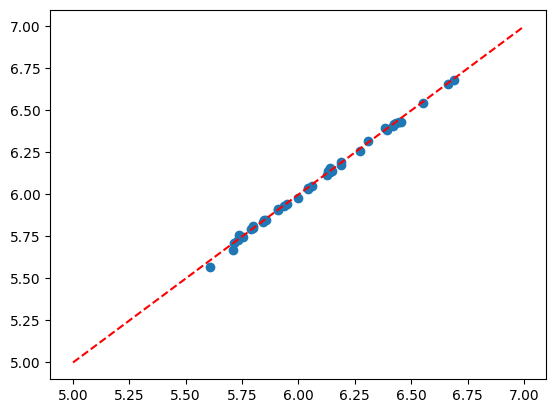

In [ ]:
plt.scatter(flux1.log10(), flux2.log10())
plt.plot([5, 7], [5, 7], linestyle='--', color='r')


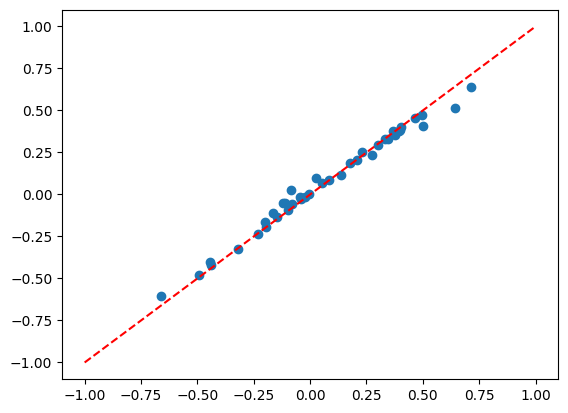

In [ ]:
plt.scatter(ellips1[:, 0], ellips2[:, 0])
plt.plot([-1, 1], [-1, 1], linestyle='--', color='r')


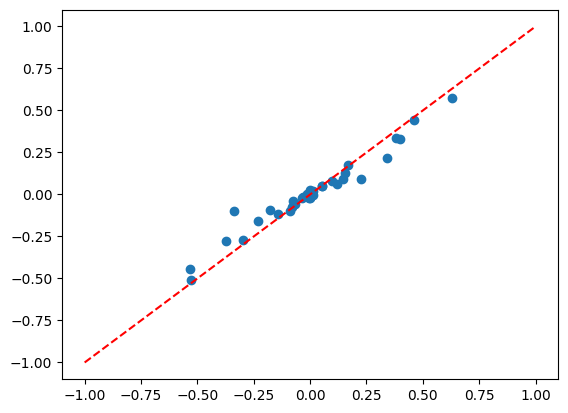

In [ ]:
plt.scatter(ellips1[:, 1], ellips2[:, 1])
plt.plot([-1, 1], [-1, 1], linestyle='--', color='r')


# Fit multiple but small number of galaxies (2), again only bright

In [ ]:
# smaller dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
cat = catsim_table[ (catsim_table["i_ab"] < 23) & (catsim_table["i_ab"] > 20)]
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
star_mags = all_star_mags[all_star_mags > 20]
psf = get_default_lsst_psf()

n_samples = 50
dataset = generate_dataset(n_samples, cat, star_mags, psf, slen=40, bp=24, max_n_sources=2,galaxy_density=100000, star_density=0, max_shift=0.5, add_galaxies_in_padding=False)


100%|██████████| 50/50 [00:00<00:00, 67.97it/s]


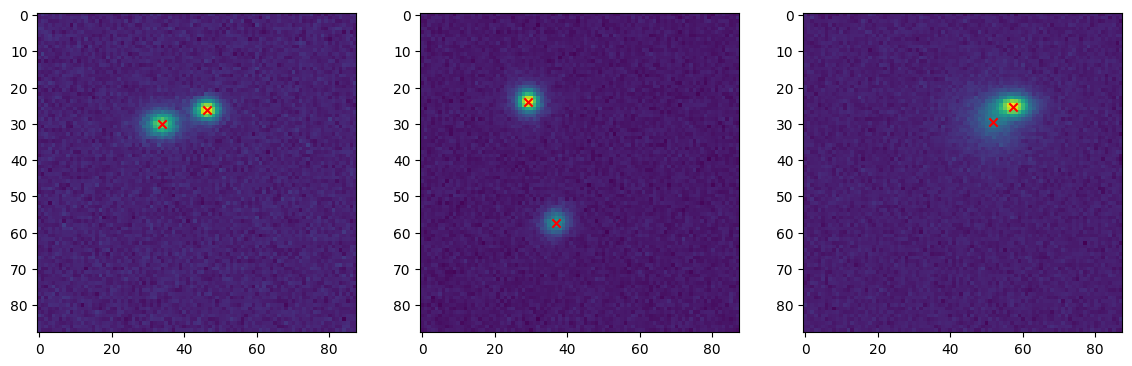

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    # # plot the 4 tiles
    # for ii in range(2):
    #     for jj in range(2):
    #         rect = patches.Rectangle((27.5-4+ii*4, 27.5-4+jj*4), 4, 4, linewidth=1, edgecolor='c', facecolor='none')
    #         ax.add_patch(rect)


    plocs = dataset['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# setup training datasets
# train, test split
train_idx = 40
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

# now save  data
torch.save(train_ds, "train_ds4.pt")
torch.save(val_ds, "val_ds4.pt")
# create datasets
train_dataset = SavedGalsimBlends("train_ds4.pt", 40, slen=40, keep_padding=True)
validation_dataset = SavedGalsimBlends("val_ds4.pt", 10, slen=40, keep_padding=True)
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 40, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=10)
# now train on the same batch 100 times with some optimizer 


In [ ]:

from torch.optim import Adam
from tqdm import tqdm
encoder = GalaxyEncoder('../models/autoencoder.pt')

# gpu 
gpu = torch.device("cuda:0")
encoder.to(gpu)

opt = Adam(encoder.parameters(), lr=1e-2)


for ii in tqdm(range(1000), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat, paddings = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        paddings = paddings.to(gpu)
        loss = encoder.get_loss(images, paddings, background, truth_cat)
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        train_n_batches+=1 

    running_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   1%|          | 8/1000 [00:01<01:55,  8.57it/s]

epoch: 4 ,training_loss:  3220840.0
epoch: 9 ,training_loss:  5635920.0


epoch::   2%|▏         | 20/1000 [00:01<00:45, 21.49it/s]

epoch: 14 ,training_loss:  4857310.0
epoch: 19 ,training_loss:  3938393.75


epoch::   3%|▎         | 28/1000 [00:01<00:35, 27.04it/s]

epoch: 24 ,training_loss:  3214722.0
epoch: 29 ,training_loss:  3056357.0


epoch::   4%|▍         | 40/1000 [00:02<00:30, 31.05it/s]

epoch: 34 ,training_loss:  3018217.5
epoch: 39 ,training_loss:  2959869.75


epoch::   5%|▍         | 48/1000 [00:02<00:29, 32.01it/s]

epoch: 44 ,training_loss:  2892897.5
epoch: 49 ,training_loss:  2825478.25


epoch::   6%|▌         | 60/1000 [00:02<00:28, 32.54it/s]

epoch: 54 ,training_loss:  2789617.5
epoch: 59 ,training_loss:  2743378.0


epoch::   7%|▋         | 68/1000 [00:03<00:28, 32.53it/s]

epoch: 64 ,training_loss:  2689277.75
epoch: 69 ,training_loss:  2566335.75


epoch::   8%|▊         | 80/1000 [00:03<00:28, 32.72it/s]

epoch: 74 ,training_loss:  2478640.0
epoch: 79 ,training_loss:  2436481.75


epoch::   9%|▉         | 88/1000 [00:03<00:27, 32.76it/s]

epoch: 84 ,training_loss:  2420516.5
epoch: 89 ,training_loss:  2401748.0


epoch::  10%|█         | 100/1000 [00:04<00:27, 32.98it/s]

epoch: 94 ,training_loss:  2385570.75
epoch: 99 ,training_loss:  2377905.25


epoch::  11%|█         | 108/1000 [00:04<00:27, 33.00it/s]

epoch: 104 ,training_loss:  2371469.5
epoch: 109 ,training_loss:  2365377.25


epoch::  12%|█▏        | 120/1000 [00:04<00:26, 32.88it/s]

epoch: 114 ,training_loss:  2360808.0
epoch: 119 ,training_loss:  2357078.5


epoch::  13%|█▎        | 128/1000 [00:05<00:26, 32.54it/s]

epoch: 124 ,training_loss:  2353546.75
epoch: 129 ,training_loss:  2350587.25


epoch::  14%|█▍        | 140/1000 [00:05<00:26, 32.56it/s]

epoch: 134 ,training_loss:  2348232.0
epoch: 139 ,training_loss:  2346111.5


epoch::  15%|█▍        | 148/1000 [00:05<00:26, 32.46it/s]

epoch: 144 ,training_loss:  2343935.75
epoch: 149 ,training_loss:  2341901.75


epoch::  16%|█▌        | 160/1000 [00:05<00:25, 32.37it/s]

epoch: 154 ,training_loss:  2340028.75
epoch: 159 ,training_loss:  2338218.5


epoch::  17%|█▋        | 168/1000 [00:06<00:25, 32.57it/s]

epoch: 164 ,training_loss:  2336614.5
epoch: 169 ,training_loss:  2334945.25


epoch::  18%|█▊        | 180/1000 [00:06<00:25, 32.69it/s]

epoch: 174 ,training_loss:  2333560.25
epoch: 179 ,training_loss:  2332394.0


epoch::  19%|█▉        | 188/1000 [00:06<00:24, 32.81it/s]

epoch: 184 ,training_loss:  2331468.0
epoch: 189 ,training_loss:  2330725.0


epoch::  20%|██        | 200/1000 [00:07<00:24, 32.78it/s]

epoch: 194 ,training_loss:  2330130.75
epoch: 199 ,training_loss:  2329570.25


epoch::  21%|██        | 208/1000 [00:07<00:24, 32.76it/s]

epoch: 204 ,training_loss:  2329107.0
epoch: 209 ,training_loss:  2328708.0


epoch::  22%|██▏       | 220/1000 [00:07<00:24, 32.49it/s]

epoch: 214 ,training_loss:  2328373.0
epoch: 219 ,training_loss:  2328062.75


epoch::  23%|██▎       | 228/1000 [00:08<00:23, 32.87it/s]

epoch: 224 ,training_loss:  2327792.0
epoch: 229 ,training_loss:  2327546.25


epoch::  24%|██▍       | 240/1000 [00:08<00:23, 32.94it/s]

epoch: 234 ,training_loss:  2327326.5
epoch: 239 ,training_loss:  2327116.75


epoch::  25%|██▍       | 248/1000 [00:08<00:22, 32.92it/s]

epoch: 244 ,training_loss:  2326917.0
epoch: 249 ,training_loss:  2326735.75


epoch::  26%|██▌       | 260/1000 [00:09<00:22, 32.97it/s]

epoch: 254 ,training_loss:  2326502.0
epoch: 259 ,training_loss:  2326311.25


epoch::  27%|██▋       | 268/1000 [00:09<00:22, 32.80it/s]

epoch: 264 ,training_loss:  2326138.0
epoch: 269 ,training_loss:  2325981.25


epoch::  28%|██▊       | 280/1000 [00:09<00:21, 32.78it/s]

epoch: 274 ,training_loss:  2325835.0
epoch: 279 ,training_loss:  2325695.0


epoch::  29%|██▉       | 288/1000 [00:09<00:21, 32.83it/s]

epoch: 284 ,training_loss:  2325572.0
epoch: 289 ,training_loss:  2325460.5


epoch::  30%|███       | 300/1000 [00:10<00:21, 32.60it/s]

epoch: 294 ,training_loss:  2325357.0
epoch: 299 ,training_loss:  2325257.25


epoch::  31%|███       | 308/1000 [00:10<00:21, 32.10it/s]

epoch: 304 ,training_loss:  2325164.5
epoch: 309 ,training_loss:  2325069.25


epoch::  32%|███▏      | 320/1000 [00:10<00:21, 32.24it/s]

epoch: 314 ,training_loss:  2324973.5
epoch: 319 ,training_loss:  2324887.0


epoch::  33%|███▎      | 328/1000 [00:11<00:20, 32.32it/s]

epoch: 324 ,training_loss:  2324793.0
epoch: 329 ,training_loss:  2324718.5


epoch::  34%|███▍      | 340/1000 [00:11<00:20, 32.24it/s]

epoch: 334 ,training_loss:  2324649.0
epoch: 339 ,training_loss:  2324580.0


epoch::  35%|███▍      | 348/1000 [00:11<00:20, 32.28it/s]

epoch: 344 ,training_loss:  2324516.0
epoch: 349 ,training_loss:  2324442.0


epoch::  36%|███▌      | 360/1000 [00:12<00:19, 32.61it/s]

epoch: 354 ,training_loss:  2324364.25
epoch: 359 ,training_loss:  2324289.0


epoch::  37%|███▋      | 368/1000 [00:12<00:19, 32.72it/s]

epoch: 364 ,training_loss:  2324220.5
epoch: 369 ,training_loss:  2324151.0


epoch::  38%|███▊      | 380/1000 [00:12<00:19, 32.59it/s]

epoch: 374 ,training_loss:  2324089.0
epoch: 379 ,training_loss:  2324032.25


epoch::  39%|███▉      | 388/1000 [00:12<00:18, 32.37it/s]

epoch: 384 ,training_loss:  2323975.5
epoch: 389 ,training_loss:  2323922.75


epoch::  40%|████      | 400/1000 [00:13<00:18, 32.20it/s]

epoch: 394 ,training_loss:  2323872.5
epoch: 399 ,training_loss:  2323823.75


epoch::  41%|████      | 408/1000 [00:13<00:18, 32.13it/s]

epoch: 404 ,training_loss:  2323778.75
epoch: 409 ,training_loss:  2323730.0


epoch::  42%|████▏     | 420/1000 [00:13<00:18, 32.17it/s]

epoch: 414 ,training_loss:  2323686.0
epoch: 419 ,training_loss:  2323644.0


epoch::  43%|████▎     | 428/1000 [00:14<00:17, 32.17it/s]

epoch: 424 ,training_loss:  2323603.0
epoch: 429 ,training_loss:  2323538.5


epoch::  44%|████▍     | 440/1000 [00:14<00:17, 32.37it/s]

epoch: 434 ,training_loss:  2323496.25
epoch: 439 ,training_loss:  2323466.5


epoch::  45%|████▍     | 448/1000 [00:14<00:17, 32.43it/s]

epoch: 444 ,training_loss:  2323428.25
epoch: 449 ,training_loss:  2323425.5


epoch::  46%|████▌     | 460/1000 [00:15<00:16, 32.49it/s]

epoch: 454 ,training_loss:  2323376.25
epoch: 459 ,training_loss:  2323351.0


epoch::  47%|████▋     | 468/1000 [00:15<00:16, 32.93it/s]

epoch: 464 ,training_loss:  2323334.0
epoch: 469 ,training_loss:  2323303.75


epoch::  48%|████▊     | 480/1000 [00:15<00:15, 32.63it/s]

epoch: 474 ,training_loss:  2323288.5
epoch: 479 ,training_loss:  2323266.0


epoch::  49%|████▉     | 488/1000 [00:16<00:15, 32.77it/s]

epoch: 484 ,training_loss:  2323253.0
epoch: 489 ,training_loss:  2323254.0


epoch::  50%|█████     | 500/1000 [00:16<00:15, 32.90it/s]

epoch: 494 ,training_loss:  2323241.5
epoch: 499 ,training_loss:  2323192.25


epoch::  51%|█████     | 508/1000 [00:16<00:14, 32.88it/s]

epoch: 504 ,training_loss:  2323166.0
epoch: 509 ,training_loss:  2323144.5


epoch::  52%|█████▏    | 520/1000 [00:17<00:14, 32.95it/s]

epoch: 514 ,training_loss:  2323123.75
epoch: 519 ,training_loss:  2323140.5


epoch::  53%|█████▎    | 528/1000 [00:17<00:14, 32.73it/s]

epoch: 524 ,training_loss:  2323089.75
epoch: 529 ,training_loss:  2323071.0


epoch::  54%|█████▍    | 540/1000 [00:17<00:14, 32.76it/s]

epoch: 534 ,training_loss:  2323097.25
epoch: 539 ,training_loss:  2323103.0


epoch::  55%|█████▍    | 548/1000 [00:17<00:13, 32.45it/s]

epoch: 544 ,training_loss:  2323036.25
epoch: 549 ,training_loss:  2323011.0


epoch::  56%|█████▌    | 560/1000 [00:18<00:13, 32.53it/s]

epoch: 554 ,training_loss:  2322992.5
epoch: 559 ,training_loss:  2322995.5


epoch::  57%|█████▋    | 568/1000 [00:18<00:13, 32.44it/s]

epoch: 564 ,training_loss:  2322950.25
epoch: 569 ,training_loss:  2322949.5


epoch::  58%|█████▊    | 580/1000 [00:18<00:13, 32.29it/s]

epoch: 574 ,training_loss:  2322956.25
epoch: 579 ,training_loss:  2322918.0


epoch::  59%|█████▉    | 588/1000 [00:19<00:12, 32.68it/s]

epoch: 584 ,training_loss:  2322911.25
epoch: 589 ,training_loss:  2322897.5


epoch::  60%|██████    | 600/1000 [00:19<00:12, 32.77it/s]

epoch: 594 ,training_loss:  2322892.25
epoch: 599 ,training_loss:  2322941.25


epoch::  61%|██████    | 608/1000 [00:19<00:11, 32.68it/s]

epoch: 604 ,training_loss:  2322922.5
epoch: 609 ,training_loss:  2322925.5


epoch::  62%|██████▏   | 620/1000 [00:20<00:11, 32.38it/s]

epoch: 614 ,training_loss:  2322867.5
epoch: 619 ,training_loss:  2322859.5


epoch::  63%|██████▎   | 628/1000 [00:20<00:11, 32.43it/s]

epoch: 624 ,training_loss:  2322850.25
epoch: 629 ,training_loss:  2322855.25


epoch::  64%|██████▍   | 640/1000 [00:20<00:11, 32.71it/s]

epoch: 634 ,training_loss:  2322840.25
epoch: 639 ,training_loss:  2322818.25


epoch::  65%|██████▍   | 648/1000 [00:20<00:10, 32.42it/s]

epoch: 644 ,training_loss:  2322819.25
epoch: 649 ,training_loss:  2322790.25


epoch::  66%|██████▌   | 660/1000 [00:21<00:10, 32.79it/s]

epoch: 654 ,training_loss:  2322767.0
epoch: 659 ,training_loss:  2322773.5


epoch::  67%|██████▋   | 668/1000 [00:21<00:10, 32.82it/s]

epoch: 664 ,training_loss:  2322878.5
epoch: 669 ,training_loss:  2322895.5


epoch::  68%|██████▊   | 680/1000 [00:21<00:09, 32.80it/s]

epoch: 674 ,training_loss:  2322766.0
epoch: 679 ,training_loss:  2322800.75


epoch::  69%|██████▉   | 688/1000 [00:22<00:09, 32.71it/s]

epoch: 684 ,training_loss:  2322823.75
epoch: 689 ,training_loss:  2322902.0


epoch::  70%|███████   | 700/1000 [00:22<00:09, 32.57it/s]

epoch: 694 ,training_loss:  2322793.5
epoch: 699 ,training_loss:  2322733.0


epoch::  71%|███████   | 708/1000 [00:22<00:08, 32.69it/s]

epoch: 704 ,training_loss:  2322792.5
epoch: 709 ,training_loss:  2322766.5


epoch::  72%|███████▏  | 720/1000 [00:23<00:08, 32.72it/s]

epoch: 714 ,training_loss:  2322719.75
epoch: 719 ,training_loss:  2322779.0


epoch::  73%|███████▎  | 728/1000 [00:23<00:08, 32.75it/s]

epoch: 724 ,training_loss:  2322728.0
epoch: 729 ,training_loss:  2322714.0


epoch::  74%|███████▍  | 740/1000 [00:23<00:07, 32.81it/s]

epoch: 734 ,training_loss:  2322719.0
epoch: 739 ,training_loss:  2322694.0


epoch::  75%|███████▍  | 748/1000 [00:24<00:07, 32.60it/s]

epoch: 744 ,training_loss:  2322731.0
epoch: 749 ,training_loss:  2322744.0


epoch::  76%|███████▌  | 760/1000 [00:24<00:07, 32.82it/s]

epoch: 754 ,training_loss:  2323043.5
epoch: 759 ,training_loss:  2323113.75


epoch::  77%|███████▋  | 768/1000 [00:24<00:07, 32.45it/s]

epoch: 764 ,training_loss:  2322871.5
epoch: 769 ,training_loss:  2322683.5


epoch::  78%|███████▊  | 780/1000 [00:25<00:06, 32.64it/s]

epoch: 774 ,training_loss:  2322705.25
epoch: 779 ,training_loss:  2322717.0


epoch::  79%|███████▉  | 788/1000 [00:25<00:06, 32.87it/s]

epoch: 784 ,training_loss:  2322669.75
epoch: 789 ,training_loss:  2322717.5


epoch::  80%|████████  | 800/1000 [00:25<00:06, 32.85it/s]

epoch: 794 ,training_loss:  2322672.0
epoch: 799 ,training_loss:  2322682.5


epoch::  81%|████████  | 808/1000 [00:25<00:05, 32.71it/s]

epoch: 804 ,training_loss:  2322748.5
epoch: 809 ,training_loss:  2322675.0


epoch::  82%|████████▏ | 820/1000 [00:26<00:05, 32.89it/s]

epoch: 814 ,training_loss:  2322728.5
epoch: 819 ,training_loss:  2322690.5


epoch::  83%|████████▎ | 828/1000 [00:26<00:05, 32.66it/s]

epoch: 824 ,training_loss:  2322656.0
epoch: 829 ,training_loss:  2322720.0


epoch::  84%|████████▍ | 840/1000 [00:26<00:04, 32.57it/s]

epoch: 834 ,training_loss:  2322654.5
epoch: 839 ,training_loss:  2322653.5


epoch::  85%|████████▍ | 848/1000 [00:27<00:04, 32.46it/s]

epoch: 844 ,training_loss:  2322696.25
epoch: 849 ,training_loss:  2322714.5


epoch::  86%|████████▌ | 860/1000 [00:27<00:04, 32.49it/s]

epoch: 854 ,training_loss:  2322703.0
epoch: 859 ,training_loss:  2322650.5


epoch::  87%|████████▋ | 868/1000 [00:27<00:04, 32.24it/s]

epoch: 864 ,training_loss:  2322638.25
epoch: 869 ,training_loss:  2322723.5


epoch::  88%|████████▊ | 880/1000 [00:28<00:03, 32.69it/s]

epoch: 874 ,training_loss:  2323295.25
epoch: 879 ,training_loss:  2322722.75


epoch::  89%|████████▉ | 888/1000 [00:28<00:03, 32.26it/s]

epoch: 884 ,training_loss:  2322895.0
epoch: 889 ,training_loss:  2322667.0


epoch::  90%|█████████ | 900/1000 [00:28<00:03, 32.33it/s]

epoch: 894 ,training_loss:  2322668.0
epoch: 899 ,training_loss:  2322641.25


epoch::  91%|█████████ | 908/1000 [00:28<00:02, 32.33it/s]

epoch: 904 ,training_loss:  2322608.5
epoch: 909 ,training_loss:  2322623.0


epoch::  92%|█████████▏| 920/1000 [00:29<00:02, 32.56it/s]

epoch: 914 ,training_loss:  2322626.5
epoch: 919 ,training_loss:  2322630.75


epoch::  93%|█████████▎| 928/1000 [00:29<00:02, 32.60it/s]

epoch: 924 ,training_loss:  2322664.0
epoch: 929 ,training_loss:  2322586.25


epoch::  94%|█████████▍| 940/1000 [00:29<00:01, 32.70it/s]

epoch: 934 ,training_loss:  2322591.5
epoch: 939 ,training_loss:  2322597.5


epoch::  95%|█████████▍| 948/1000 [00:30<00:01, 32.75it/s]

epoch: 944 ,training_loss:  2322687.0
epoch: 949 ,training_loss:  2322857.25


epoch::  96%|█████████▌| 960/1000 [00:30<00:01, 32.78it/s]

epoch: 954 ,training_loss:  2322821.0
epoch: 959 ,training_loss:  2322521.0


epoch::  97%|█████████▋| 968/1000 [00:30<00:00, 32.87it/s]

epoch: 964 ,training_loss:  2322530.0
epoch: 969 ,training_loss:  2322510.25


epoch::  98%|█████████▊| 980/1000 [00:31<00:00, 32.92it/s]

epoch: 974 ,training_loss:  2322490.75
epoch: 979 ,training_loss:  2322498.0


epoch::  99%|█████████▉| 988/1000 [00:31<00:00, 32.86it/s]

epoch: 984 ,training_loss:  2322487.75
epoch: 989 ,training_loss:  2322755.5


epoch:: 100%|██████████| 1000/1000 [00:31<00:00, 31.49it/s]

epoch: 994 ,training_loss:  2323693.25
epoch: 999 ,training_loss:  2322518.5


In [ ]:
from torch import Tensor
from bliss.render_tiles import render_galaxy_ptiles, reconstruct_image_from_ptiles
from bliss.datasets.lsst import get_default_lsst_psf_tensor
from bliss.catalog import FullCatalog

# look at some predictions!
model_cpu = encoder.to(torch.device("cpu"))
model_cpu.eval()


# let's run it on the entire training dataset
blend_data: dict[str, Tensor] = torch.load("train_ds4.pt")
images = blend_data.pop("images").float()
background = blend_data.pop("background").float()
individuals = blend_data.pop("individuals").float()
blend_data.pop("noiseless")
blend_data.pop("paddings")

n_batches, _, size, _ = images.shape
assert background.shape == images.shape

# get psf
psf_tensor = get_default_lsst_psf_tensor(size)

# obtain `FullCatalog` from saved data
slen = size - 2 * (model_cpu.bp)
full_cat = FullCatalog(slen, slen, blend_data)
truth_cat = full_cat.to_tile_params(4, ignore_extra_sources=True)

In [ ]:

# save  images of residuals + flux scatter + ellipticity in a separate PDF
with torch.no_grad():
    galaxy_params_tiled = model_cpu.variational_mode(images, background, truth_cat)
    galaxies = render_galaxy_ptiles(model_cpu._dec, truth_cat.locs, 
                                    galaxy_params_tiled, truth_cat['galaxy_bools'], 
                                    52, 4)
    pred_images = reconstruct_image_from_ptiles(galaxies, 4) + background.mean()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# compare both galaxies side by side
fig, axes = plt.subplots(20, 3, figsize=(8, 40))
for ii, (ax1, ax2, ax3) in enumerate(axes):
    im1 = ax1.imshow(images[ii, 0])
    im2 = ax2.imshow(pred_images[ii, 0])
    im3 = ax3.imshow( (pred_images[ii, 0] - images[ii, 0]) /  pred_images[ii,0].sqrt() )

    for im, ax in zip((im1,im2,im3), (ax1,ax2,ax3)):
        divider = make_axes_locatable(ax)
        cax =  divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
_ = fig.savefig('residuals4.pdf');
plt.close(fig)

# Same number of galaxies, but also add padding (still only bright)

In [ ]:
# smaller dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
cat = catsim_table[ (catsim_table["i_ab"] < 23) & (catsim_table["i_ab"] > 20)]
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
star_mags = all_star_mags[all_star_mags > 20]
psf = get_default_lsst_psf()

n_samples = 50
dataset = generate_dataset(n_samples, cat, star_mags, psf, slen=40, bp=24, max_n_sources=1,galaxy_density=185, star_density=0, max_shift=0.5, add_galaxies_in_padding=True)


100%|██████████| 50/50 [00:04<00:00, 12.18it/s]


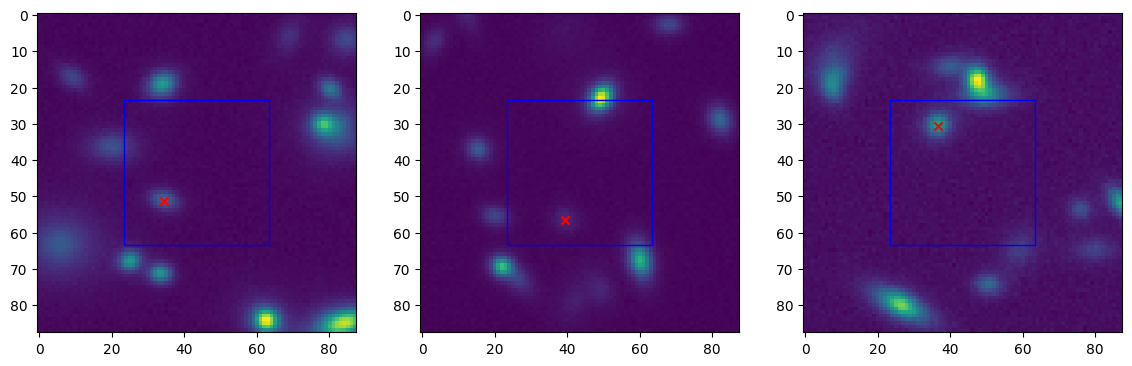

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    rect = patches.Rectangle((43.5-20, 43.5-20), 40, 40, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)


    plocs = dataset['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# setup training datasets
# train, test split
train_idx = 40
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

# now save  data
torch.save(train_ds, "train_ds5.pt")
torch.save(val_ds, "val_ds5.pt")
# create datasets
train_dataset = SavedGalsimBlends("train_ds5.pt", 40, slen=40, keep_padding=True)
validation_dataset = SavedGalsimBlends("val_ds5.pt", 10, slen=40, keep_padding=True)
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 40, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=10)
# now train on the same batch 100 times with some optimizer 


In [ ]:

from torch.optim import Adam
from tqdm import tqdm
encoder = GalaxyEncoder('../models/autoencoder.pt')

# gpu 
gpu = torch.device("cuda:0")
encoder.to(gpu)

opt = Adam(encoder.parameters(), lr=1e-2)


for ii in tqdm(range(1000), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat, paddings = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        paddings = paddings.to(gpu)
        loss = encoder.get_loss(images, paddings, background, truth_cat)
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        train_n_batches+=1 

    running_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

In [ ]:
from torch import Tensor
from bliss.render_tiles import render_galaxy_ptiles, reconstruct_image_from_ptiles
from bliss.datasets.lsst import get_default_lsst_psf_tensor
from bliss.catalog import FullCatalog

# look at some predictions!
model_cpu = encoder.to(torch.device("cpu"))
model_cpu.eval()


# let's run it on the entire training dataset
blend_data: dict[str, Tensor] = torch.load("train_ds5.pt")
images = blend_data.pop("images").float() 
background = blend_data.pop("background").float()
individuals = blend_data.pop("individuals").float()
blend_data.pop("noiseless")
paddings = blend_data.pop('paddings')

n_batches, _, size, _ = images.shape
assert background.shape == images.shape

# get psf
psf_tensor = get_default_lsst_psf_tensor(size)

# obtain `FullCatalog` from saved data
slen = size - 2 * (model_cpu.bp)
full_cat = FullCatalog(slen, slen, blend_data)
truth_cat = full_cat.to_tile_params(4, ignore_extra_sources=True)

In [ ]:

# save  images of residuals + flux scatter + ellipticity in a separate PDF
with torch.no_grad():
    galaxy_params_tiled = model_cpu.variational_mode(images, background, truth_cat)
    galaxies = render_galaxy_ptiles(model_cpu._dec, truth_cat.locs, 
                                    galaxy_params_tiled, truth_cat['galaxy_bools'], 
                                    52, 4)
    pred_images = reconstruct_image_from_ptiles(galaxies, 4) + background.mean()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# compare both galaxies side by side
fig, axes = plt.subplots(20, 3, figsize=(8, 40))
for ii, (ax1, ax2, ax3) in enumerate(axes):
    im1 = ax1.imshow(images[ii, 0])
    im2 = ax2.imshow(pred_images[ii, 0])
    im3 = ax3.imshow( (pred_images[ii, 0] - images[ii, 0] + paddings[ii, 0]) /  pred_images[ii,0].sqrt() )

    for im, ax in zip((im1,im2,im3), (ax1,ax2,ax3)):
        divider = make_axes_locatable(ax)
        cax =  divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
_ = fig.savefig('residuals5.pdf');
plt.close(fig)

# Same as above, but let's add 2 objects with in average 1 of them being stars

In [ ]:
# smaller dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
cat = catsim_table[ (catsim_table["i_ab"] < 23) & (catsim_table["i_ab"] > 20)]
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
star_mags = all_star_mags[all_star_mags > 20]
psf = get_default_lsst_psf()

n_samples = 50
dataset = generate_dataset(n_samples, cat, star_mags, psf, slen=40, bp=24, max_n_sources=2,galaxy_density=150, star_density=50, max_shift=0.5, add_galaxies_in_padding=True)


 16%|█▌        | 8/50 [00:00<00:03, 12.14it/s]

100%|██████████| 50/50 [00:03<00:00, 13.71it/s]


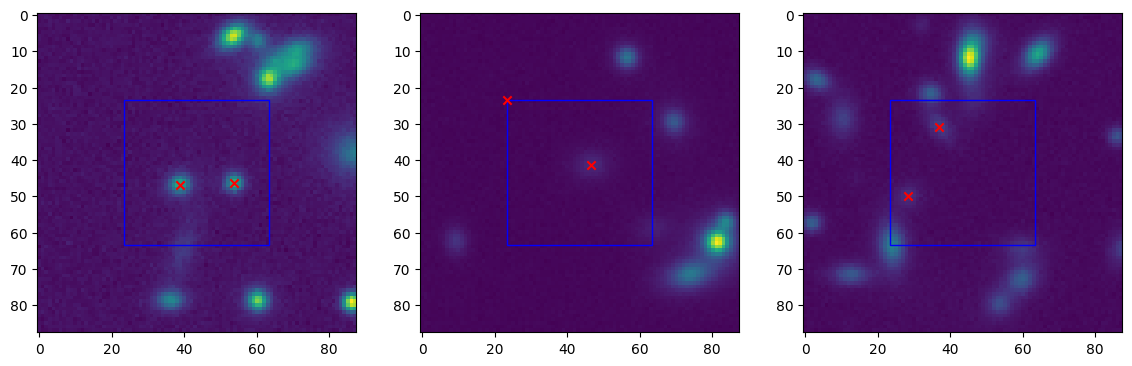

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    rect = patches.Rectangle((43.5-20, 43.5-20), 40, 40, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)


    plocs = dataset['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# setup training datasets
# train, test split
train_idx = 40
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

# now save  data
torch.save(train_ds, "train_ds6.pt")
torch.save(val_ds, "val_ds6.pt")
# create datasets
train_dataset = SavedGalsimBlends("train_ds6.pt", 40, slen=40, keep_padding=True)
validation_dataset = SavedGalsimBlends("val_ds6.pt", 10, slen=40, keep_padding=True)
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 40, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=10)
# now train on the same batch 100 times with some optimizer 


In [ ]:

from torch.optim import Adam
from tqdm import tqdm
encoder = GalaxyEncoder('../models/autoencoder.pt')

# gpu 
gpu = torch.device("cuda:0")
encoder.to(gpu)

opt = Adam(encoder.parameters(), lr=1e-2)


for ii in tqdm(range(1000), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat, paddings = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        paddings = paddings.to(gpu)
        loss = encoder.get_loss(images, paddings, background, truth_cat)
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        train_n_batches+=1 

    running_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

In [ ]:
from torch import Tensor
from bliss.render_tiles import render_galaxy_ptiles, reconstruct_image_from_ptiles
from bliss.datasets.lsst import get_default_lsst_psf_tensor
from bliss.catalog import FullCatalog

# look at some predictions!
model_cpu = encoder.to(torch.device("cpu"))
model_cpu.eval()


# let's run it on the entire training dataset
blend_data: dict[str, Tensor] = torch.load("train_ds6.pt")
images = blend_data.pop("images").float() 
background = blend_data.pop("background").float()
individuals = blend_data.pop("individuals").float()
blend_data.pop("noiseless")
paddings = blend_data.pop('paddings')

n_batches, _, size, _ = images.shape
assert background.shape == images.shape

# get psf
psf_tensor = get_default_lsst_psf_tensor(size)

# obtain `FullCatalog` from saved data
slen = size - 2 * (model_cpu.bp)
full_cat = FullCatalog(slen, slen, blend_data)
truth_cat = full_cat.to_tile_params(4, ignore_extra_sources=True)

In [ ]:

# save  images of residuals + flux scatter + ellipticity in a separate PDF
with torch.no_grad():
    galaxy_params_tiled = model_cpu.variational_mode(images, background, truth_cat)
    galaxies = render_galaxy_ptiles(model_cpu._dec, truth_cat.locs, 
                                    galaxy_params_tiled, truth_cat['galaxy_bools'], 
                                    52, 4)
    pred_images = reconstruct_image_from_ptiles(galaxies, 4) + background.mean()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# compare both galaxies side by side
fig, axes = plt.subplots(20, 3, figsize=(8, 40))
for ii, (ax1, ax2, ax3) in enumerate(axes):
    im1 = ax1.imshow(images[ii, 0])
    im2 = ax2.imshow(pred_images[ii, 0])
    im3 = ax3.imshow( (pred_images[ii, 0] - images[ii, 0] + paddings[ii, 0]) /  pred_images[ii,0].sqrt() )

    for im, ax in zip((im1,im2,im3), (ax1,ax2,ax3)):
        divider = make_axes_locatable(ax)
        cax =  divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    
    n_sources = full_cat.n_sources[ii]
    plocs = full_cat.plocs[ii]
    galaxy_bools = full_cat['galaxy_bools'][ii]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24
    for jj in range(n_sources):
        if galaxy_bools[jj] > 0: 
            ax1.scatter(x[jj], y[jj], marker='x', color='r', s=24)
        else: 
            ax1.scatter(x[jj], y[jj], marker='x', color='b', s=24)

plt.tight_layout()
_ = fig.savefig('residuals6.pdf');
plt.close(fig)

# Full dataset Overfitting

In [ ]:
# smaller dataset
catsim_table = Table.read("../../../data/OneDegSq.fits")
cat = catsim_table[ (catsim_table["i_ab"] < 27.3) ]
all_star_mags = column_to_tensor(Table.read("../../../data/stars_med_june2018.fits"), "i_ab")
star_mags = all_star_mags[all_star_mags > 20]
psf = get_default_lsst_psf()

n_samples = 50
dataset = generate_dataset(n_samples, cat, star_mags, psf, slen=40, bp=24, max_n_sources=11,galaxy_density=185, star_density=10, max_shift=0.5, add_galaxies_in_padding=True)


100%|██████████| 50/50 [00:03<00:00, 14.72it/s]


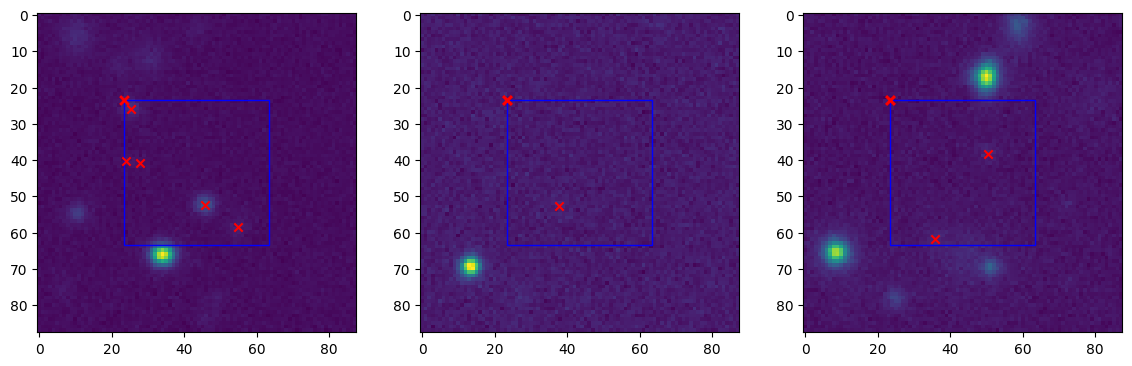

In [ ]:
# check that 3 random images are in the format we expect
import numpy as np
import matplotlib.patches as patches


rand_indices = np.random.choice(range(n_samples), size=3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(14, 8))
for ii, idx in enumerate(rand_indices):
    ax = axes.flatten()[ii]

    ax.imshow(dataset['images'][idx][0])

    rect = patches.Rectangle((43.5-20, 43.5-20), 40, 40, linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(rect)


    plocs = dataset['plocs'][idx]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24

    ax.scatter(x, y, marker='x', color='r')


In [ ]:
# setup training datasets
# train, test split
train_idx = 40
train_ds = {p:q[:train_idx] for p,q in dataset.items()}
val_ds = {p:q[train_idx:] for p,q in dataset.items()}

# now save  data
torch.save(train_ds, "train_ds7.pt")
torch.save(val_ds, "val_ds7.pt")
# create datasets
train_dataset = SavedGalsimBlends("train_ds7.pt", 40, slen=40, keep_padding=True)
validation_dataset = SavedGalsimBlends("val_ds7.pt", 10, slen=40, keep_padding=True)
# now dataloaders 
from torch.utils.data import DataLoader
train_dl = DataLoader(train_dataset, batch_size = 40, shuffle=True)
val_dl = DataLoader(validation_dataset, batch_size=10)
# now train on the same batch 100 times with some optimizer 


In [ ]:

from torch.optim import Adam
from tqdm import tqdm
encoder = GalaxyEncoder('../models/autoencoder.pt')

# gpu 
gpu = torch.device("cuda:0")
encoder.to(gpu)

opt = Adam(encoder.parameters(), lr=1e-2)


for ii in tqdm(range(1000), desc='epoch:'):

    # train 
    running_loss = 0.
    running_locs_loss = 0.
    running_counter_loss = 0.
    train_n_batches = 0
    encoder.train()
    for tbatch in train_dl:
        opt.zero_grad()
        images, background, truth_cat, paddings = parse_dataset(tbatch)
        images= images.to(gpu)
        background = background.to(gpu)
        truth_cat = truth_cat.to(gpu)
        paddings = paddings.to(gpu)
        loss = encoder.get_loss(images, paddings, background, truth_cat)
        loss.backward()
        opt.step()

        running_loss += loss.detach().cpu().item()
        train_n_batches+=1 

    running_loss /= train_n_batches

    if ii % 5 == 4:

        print('epoch:', ii, ',training_loss: ', running_loss)

    # if ii % 4 == 3:
    #     val_running_loss = 0.
    #     val_n_batches = 0
    #     detection_encoder.eval()
    #     with torch.no_grad():
    #         for bval in val_dl:
    #             images, background, truth_catalog = parse_dataset(bval)
    #             images = images.to(gpu)
    #             background = background.to(gpu)
    #             truth_catalog = truth_catalog.to(gpu)

    #             val_loss = detection_encoder.get_loss(images, background, truth_catalog)['loss']
    #             val_running_loss += val_loss.detach().cpu().item()
    #             val_n_batches +=1
    #     val_running_loss/= val_n_batches
    #     print('epoch: ', ii, ', val_loss: ', val_running_loss)

epoch::   1%|          | 8/1000 [00:01<01:57,  8.43it/s]

epoch: 4 ,training_loss:  2427855.5
epoch: 9 ,training_loss:  2381893.25


epoch::   2%|▏         | 20/1000 [00:01<00:45, 21.48it/s]

epoch: 14 ,training_loss:  2344125.75
epoch: 19 ,training_loss:  2342860.0


epoch::   3%|▎         | 32/1000 [00:02<00:32, 29.39it/s]

epoch: 24 ,training_loss:  2339912.5
epoch: 29 ,training_loss:  2333599.25


epoch::   4%|▍         | 40/1000 [00:02<00:29, 32.02it/s]

epoch: 34 ,training_loss:  2330069.5
epoch: 39 ,training_loss:  2328774.75


epoch::   5%|▍         | 48/1000 [00:02<00:28, 33.03it/s]

epoch: 44 ,training_loss:  2327862.5
epoch: 49 ,training_loss:  2326938.25


epoch::   6%|▌         | 60/1000 [00:02<00:27, 33.90it/s]

epoch: 54 ,training_loss:  2326184.0
epoch: 59 ,training_loss:  2325712.5


epoch::   7%|▋         | 68/1000 [00:03<00:27, 34.05it/s]

epoch: 64 ,training_loss:  2325420.5
epoch: 69 ,training_loss:  2325072.5


epoch::   8%|▊         | 80/1000 [00:03<00:27, 34.06it/s]

epoch: 74 ,training_loss:  2324683.0
epoch: 79 ,training_loss:  2324275.0


epoch::   9%|▉         | 88/1000 [00:03<00:26, 34.05it/s]

epoch: 84 ,training_loss:  2323872.5
epoch: 89 ,training_loss:  2323422.5


epoch::  10%|█         | 100/1000 [00:04<00:26, 34.12it/s]

epoch: 94 ,training_loss:  2323087.5
epoch: 99 ,training_loss:  2322658.25


epoch::  11%|█         | 108/1000 [00:04<00:26, 34.11it/s]

epoch: 104 ,training_loss:  2322216.0
epoch: 109 ,training_loss:  2321675.0


epoch::  12%|█▏        | 120/1000 [00:04<00:25, 33.99it/s]

epoch: 114 ,training_loss:  2321007.25
epoch: 119 ,training_loss:  2320441.5


epoch::  13%|█▎        | 128/1000 [00:04<00:25, 33.61it/s]

epoch: 124 ,training_loss:  2320062.5
epoch: 129 ,training_loss:  2319573.5


epoch::  14%|█▍        | 140/1000 [00:05<00:25, 34.01it/s]

epoch: 134 ,training_loss:  2319184.75
epoch: 139 ,training_loss:  2319612.0


epoch::  15%|█▍        | 148/1000 [00:05<00:25, 34.01it/s]

epoch: 144 ,training_loss:  2319074.5
epoch: 149 ,training_loss:  2318732.75


epoch::  16%|█▌        | 160/1000 [00:05<00:24, 33.82it/s]

epoch: 154 ,training_loss:  2318340.25
epoch: 159 ,training_loss:  2318086.5


epoch::  17%|█▋        | 168/1000 [00:06<00:24, 33.31it/s]

epoch: 164 ,training_loss:  2317889.75
epoch: 169 ,training_loss:  2317805.5


epoch::  18%|█▊        | 180/1000 [00:06<00:24, 33.68it/s]

epoch: 174 ,training_loss:  2317751.5
epoch: 179 ,training_loss:  2317706.5


epoch::  19%|█▉        | 188/1000 [00:06<00:24, 33.72it/s]

epoch: 184 ,training_loss:  2317666.5
epoch: 189 ,training_loss:  2317645.0


epoch::  20%|██        | 200/1000 [00:07<00:23, 34.14it/s]

epoch: 194 ,training_loss:  2317619.0
epoch: 199 ,training_loss:  2317604.0


epoch::  21%|██        | 208/1000 [00:07<00:23, 33.87it/s]

epoch: 204 ,training_loss:  2317594.5
epoch: 209 ,training_loss:  2317659.0


epoch::  22%|██▏       | 220/1000 [00:07<00:22, 33.97it/s]

epoch: 214 ,training_loss:  2318660.5
epoch: 219 ,training_loss:  2322842.75


epoch::  23%|██▎       | 228/1000 [00:07<00:22, 34.03it/s]

epoch: 224 ,training_loss:  2320341.25
epoch: 229 ,training_loss:  2318062.0


epoch::  24%|██▍       | 240/1000 [00:08<00:22, 33.96it/s]

epoch: 234 ,training_loss:  2318133.0
epoch: 239 ,training_loss:  2318288.75


epoch::  25%|██▍       | 248/1000 [00:08<00:22, 34.11it/s]

epoch: 244 ,training_loss:  2317599.75
epoch: 249 ,training_loss:  2317707.5


epoch::  26%|██▌       | 260/1000 [00:08<00:21, 34.19it/s]

epoch: 254 ,training_loss:  2317653.5
epoch: 259 ,training_loss:  2317544.25


epoch::  27%|██▋       | 268/1000 [00:09<00:21, 34.20it/s]

epoch: 264 ,training_loss:  2317562.75
epoch: 269 ,training_loss:  2317554.75


epoch::  28%|██▊       | 280/1000 [00:09<00:20, 34.30it/s]

epoch: 274 ,training_loss:  2317528.75
epoch: 279 ,training_loss:  2317517.0


epoch::  29%|██▉       | 288/1000 [00:09<00:20, 33.95it/s]

epoch: 284 ,training_loss:  2317512.25
epoch: 289 ,training_loss:  2317503.0


epoch::  30%|███       | 300/1000 [00:09<00:20, 34.12it/s]

epoch: 294 ,training_loss:  2317496.75
epoch: 299 ,training_loss:  2317495.5


epoch::  31%|███       | 308/1000 [00:10<00:20, 33.86it/s]

epoch: 304 ,training_loss:  2317487.25
epoch: 309 ,training_loss:  2317488.0


epoch::  32%|███▏      | 320/1000 [00:10<00:20, 33.82it/s]

epoch: 314 ,training_loss:  2317484.0
epoch: 319 ,training_loss:  2317471.0


epoch::  33%|███▎      | 328/1000 [00:10<00:19, 33.75it/s]

epoch: 324 ,training_loss:  2317466.5
epoch: 329 ,training_loss:  2317476.75


epoch::  34%|███▍      | 340/1000 [00:11<00:19, 33.60it/s]

epoch: 334 ,training_loss:  2317534.0
epoch: 339 ,training_loss:  2317683.25


epoch::  35%|███▍      | 348/1000 [00:11<00:19, 33.71it/s]

epoch: 344 ,training_loss:  2317778.5
epoch: 349 ,training_loss:  2317673.25


epoch::  36%|███▌      | 360/1000 [00:11<00:18, 33.87it/s]

epoch: 354 ,training_loss:  2317467.5
epoch: 359 ,training_loss:  2317463.5


epoch::  37%|███▋      | 368/1000 [00:11<00:18, 33.47it/s]

epoch: 364 ,training_loss:  2317559.5
epoch: 369 ,training_loss:  2317973.75


epoch::  38%|███▊      | 380/1000 [00:12<00:18, 33.78it/s]

epoch: 374 ,training_loss:  2318720.25
epoch: 379 ,training_loss:  2317470.5


epoch::  39%|███▉      | 388/1000 [00:12<00:18, 33.81it/s]

epoch: 384 ,training_loss:  2317696.5
epoch: 389 ,training_loss:  2317656.75


epoch::  40%|████      | 400/1000 [00:12<00:17, 33.74it/s]

epoch: 394 ,training_loss:  2317538.0
epoch: 399 ,training_loss:  2317442.75


epoch::  41%|████      | 408/1000 [00:13<00:17, 33.76it/s]

epoch: 404 ,training_loss:  2317429.5
epoch: 409 ,training_loss:  2317460.0


epoch::  42%|████▏     | 420/1000 [00:13<00:17, 33.85it/s]

epoch: 414 ,training_loss:  2317422.0
epoch: 419 ,training_loss:  2317427.5


epoch::  43%|████▎     | 428/1000 [00:13<00:16, 33.76it/s]

epoch: 424 ,training_loss:  2317407.5
epoch: 429 ,training_loss:  2317436.0


epoch::  44%|████▍     | 440/1000 [00:14<00:16, 33.63it/s]

epoch: 434 ,training_loss:  2317413.0
epoch: 439 ,training_loss:  2317398.5


epoch::  45%|████▍     | 448/1000 [00:14<00:16, 33.57it/s]

epoch: 444 ,training_loss:  2317414.0
epoch: 449 ,training_loss:  2317436.25


epoch::  46%|████▌     | 460/1000 [00:14<00:15, 33.86it/s]

epoch: 454 ,training_loss:  2317514.0
epoch: 459 ,training_loss:  2317703.75


epoch::  47%|████▋     | 468/1000 [00:14<00:15, 33.83it/s]

epoch: 464 ,training_loss:  2317854.75
epoch: 469 ,training_loss:  2317565.5


epoch::  48%|████▊     | 480/1000 [00:15<00:15, 33.91it/s]

epoch: 474 ,training_loss:  2317384.5
epoch: 479 ,training_loss:  2317483.5


epoch::  49%|████▉     | 488/1000 [00:15<00:15, 33.91it/s]

epoch: 484 ,training_loss:  2317693.5
epoch: 489 ,training_loss:  2317802.25


epoch::  50%|█████     | 500/1000 [00:15<00:14, 33.38it/s]

epoch: 494 ,training_loss:  2317576.5
epoch: 499 ,training_loss:  2317372.5


epoch::  51%|█████     | 508/1000 [00:16<00:14, 33.59it/s]

epoch: 504 ,training_loss:  2317465.5
epoch: 509 ,training_loss:  2317640.0


epoch::  52%|█████▏    | 520/1000 [00:16<00:14, 33.75it/s]

epoch: 514 ,training_loss:  2317704.5
epoch: 519 ,training_loss:  2317557.25


epoch::  53%|█████▎    | 528/1000 [00:16<00:14, 33.71it/s]

epoch: 524 ,training_loss:  2317370.5
epoch: 529 ,training_loss:  2317396.0


epoch::  54%|█████▍    | 540/1000 [00:17<00:13, 33.53it/s]

epoch: 534 ,training_loss:  2317592.75
epoch: 539 ,training_loss:  2319052.75


epoch::  55%|█████▍    | 548/1000 [00:17<00:13, 33.80it/s]

epoch: 544 ,training_loss:  2346129.0
epoch: 549 ,training_loss:  2362853.0


epoch::  56%|█████▌    | 560/1000 [00:17<00:12, 33.96it/s]

epoch: 554 ,training_loss:  2325805.5
epoch: 559 ,training_loss:  2379151.0


epoch::  57%|█████▋    | 568/1000 [00:17<00:12, 34.02it/s]

epoch: 564 ,training_loss:  2341123.5
epoch: 569 ,training_loss:  2326851.0


epoch::  58%|█████▊    | 580/1000 [00:18<00:12, 33.84it/s]

epoch: 574 ,training_loss:  2321428.75
epoch: 579 ,training_loss:  2319786.0


epoch::  59%|█████▉    | 588/1000 [00:18<00:12, 33.76it/s]

epoch: 584 ,training_loss:  2319473.75
epoch: 589 ,training_loss:  2318833.5


epoch::  60%|██████    | 600/1000 [00:18<00:11, 33.63it/s]

epoch: 594 ,training_loss:  2318383.5
epoch: 599 ,training_loss:  2318136.5


epoch::  61%|██████    | 608/1000 [00:19<00:11, 33.62it/s]

epoch: 604 ,training_loss:  2317966.25
epoch: 609 ,training_loss:  2317874.0


epoch::  62%|██████▏   | 620/1000 [00:19<00:11, 33.24it/s]

epoch: 614 ,training_loss:  2317781.0
epoch: 619 ,training_loss:  2317724.5


epoch::  63%|██████▎   | 628/1000 [00:19<00:11, 33.43it/s]

epoch: 624 ,training_loss:  2317686.5
epoch: 629 ,training_loss:  2317651.75


epoch::  64%|██████▍   | 640/1000 [00:20<00:10, 33.52it/s]

epoch: 634 ,training_loss:  2317629.75
epoch: 639 ,training_loss:  2317610.25


epoch::  65%|██████▍   | 648/1000 [00:20<00:10, 33.57it/s]

epoch: 644 ,training_loss:  2317594.5
epoch: 649 ,training_loss:  2317580.0


epoch::  66%|██████▌   | 660/1000 [00:20<00:10, 33.98it/s]

epoch: 654 ,training_loss:  2317568.5
epoch: 659 ,training_loss:  2317560.0


epoch::  67%|██████▋   | 668/1000 [00:20<00:09, 33.92it/s]

epoch: 664 ,training_loss:  2317551.5
epoch: 669 ,training_loss:  2317542.5


epoch::  68%|██████▊   | 680/1000 [00:21<00:09, 33.84it/s]

epoch: 674 ,training_loss:  2317535.5
epoch: 679 ,training_loss:  2317528.25


epoch::  69%|██████▉   | 688/1000 [00:21<00:09, 34.01it/s]

epoch: 684 ,training_loss:  2317521.25
epoch: 689 ,training_loss:  2317513.75


epoch::  70%|███████   | 700/1000 [00:21<00:08, 34.06it/s]

epoch: 694 ,training_loss:  2317505.5
epoch: 699 ,training_loss:  2317499.75


epoch::  71%|███████   | 708/1000 [00:22<00:08, 33.91it/s]

epoch: 704 ,training_loss:  2317493.75
epoch: 709 ,training_loss:  2317489.0


epoch::  72%|███████▏  | 720/1000 [00:22<00:08, 33.41it/s]

epoch: 714 ,training_loss:  2317485.0
epoch: 719 ,training_loss:  2317480.5


epoch::  73%|███████▎  | 728/1000 [00:22<00:08, 33.35it/s]

epoch: 724 ,training_loss:  2317476.0
epoch: 729 ,training_loss:  2317471.75


epoch::  74%|███████▍  | 740/1000 [00:23<00:07, 33.62it/s]

epoch: 734 ,training_loss:  2317466.5
epoch: 739 ,training_loss:  2317463.0


epoch::  75%|███████▍  | 748/1000 [00:23<00:07, 33.68it/s]

epoch: 744 ,training_loss:  2317459.75
epoch: 749 ,training_loss:  2317455.75


epoch::  76%|███████▌  | 760/1000 [00:23<00:07, 33.57it/s]

epoch: 754 ,training_loss:  2317452.0
epoch: 759 ,training_loss:  2317447.5


epoch::  77%|███████▋  | 768/1000 [00:23<00:06, 33.57it/s]

epoch: 764 ,training_loss:  2317443.5
epoch: 769 ,training_loss:  2317440.5


epoch::  78%|███████▊  | 780/1000 [00:24<00:06, 33.72it/s]

epoch: 774 ,training_loss:  2317438.0
epoch: 779 ,training_loss:  2317435.5


epoch::  79%|███████▉  | 788/1000 [00:24<00:06, 33.67it/s]

epoch: 784 ,training_loss:  2317433.75
epoch: 789 ,training_loss:  2317432.0


epoch::  80%|████████  | 800/1000 [00:24<00:05, 33.49it/s]

epoch: 794 ,training_loss:  2317429.5
epoch: 799 ,training_loss:  2317427.25


epoch::  81%|████████  | 808/1000 [00:25<00:05, 33.61it/s]

epoch: 804 ,training_loss:  2317425.0
epoch: 809 ,training_loss:  2317423.5


epoch::  82%|████████▏ | 820/1000 [00:25<00:05, 33.68it/s]

epoch: 814 ,training_loss:  2317422.0
epoch: 819 ,training_loss:  2317420.0


epoch::  83%|████████▎ | 828/1000 [00:25<00:05, 33.72it/s]

epoch: 824 ,training_loss:  2317417.25
epoch: 829 ,training_loss:  2317415.0


epoch::  84%|████████▍ | 840/1000 [00:25<00:04, 33.81it/s]

epoch: 834 ,training_loss:  2317413.0
epoch: 839 ,training_loss:  2317411.0


epoch::  85%|████████▍ | 848/1000 [00:26<00:04, 33.52it/s]

epoch: 844 ,training_loss:  2317408.5
epoch: 849 ,training_loss:  2317406.75


epoch::  86%|████████▌ | 860/1000 [00:26<00:04, 33.97it/s]

epoch: 854 ,training_loss:  2317405.0
epoch: 859 ,training_loss:  2317402.5


epoch::  87%|████████▋ | 868/1000 [00:26<00:03, 33.84it/s]

epoch: 864 ,training_loss:  2317399.25
epoch: 869 ,training_loss:  2317396.25


epoch::  88%|████████▊ | 880/1000 [00:27<00:03, 33.63it/s]

epoch: 874 ,training_loss:  2317393.75
epoch: 879 ,training_loss:  2317392.5


epoch::  89%|████████▉ | 888/1000 [00:27<00:03, 33.67it/s]

epoch: 884 ,training_loss:  2317390.5
epoch: 889 ,training_loss:  2317387.5


epoch::  90%|█████████ | 900/1000 [00:27<00:02, 33.57it/s]

epoch: 894 ,training_loss:  2317385.5
epoch: 899 ,training_loss:  2317384.5


epoch::  91%|█████████ | 908/1000 [00:28<00:02, 33.65it/s]

epoch: 904 ,training_loss:  2317382.5
epoch: 909 ,training_loss:  2317381.0


epoch::  92%|█████████▏| 920/1000 [00:28<00:02, 33.73it/s]

epoch: 914 ,training_loss:  2317378.75
epoch: 919 ,training_loss:  2317378.25


epoch::  93%|█████████▎| 928/1000 [00:28<00:02, 33.77it/s]

epoch: 924 ,training_loss:  2317377.5
epoch: 929 ,training_loss:  2317376.25


epoch::  94%|█████████▍| 940/1000 [00:28<00:01, 33.97it/s]

epoch: 934 ,training_loss:  2317374.5
epoch: 939 ,training_loss:  2317373.0


epoch::  95%|█████████▍| 948/1000 [00:29<00:01, 33.88it/s]

epoch: 944 ,training_loss:  2317371.75
epoch: 949 ,training_loss:  2317370.5


epoch::  96%|█████████▌| 960/1000 [00:29<00:01, 33.65it/s]

epoch: 954 ,training_loss:  2317369.25
epoch: 959 ,training_loss:  2317368.5


epoch::  97%|█████████▋| 968/1000 [00:29<00:00, 33.79it/s]

epoch: 964 ,training_loss:  2317368.25
epoch: 969 ,training_loss:  2317367.0


epoch::  98%|█████████▊| 980/1000 [00:30<00:00, 33.87it/s]

epoch: 974 ,training_loss:  2317366.0
epoch: 979 ,training_loss:  2317366.5


epoch::  99%|█████████▉| 988/1000 [00:30<00:00, 33.91it/s]

epoch: 984 ,training_loss:  2317363.5
epoch: 989 ,training_loss:  2317363.75


epoch:: 100%|██████████| 1000/1000 [00:30<00:00, 32.54it/s]

epoch: 994 ,training_loss:  2317362.5
epoch: 999 ,training_loss:  2317361.25


In [ ]:
from torch import Tensor
from bliss.render_tiles import render_galaxy_ptiles, reconstruct_image_from_ptiles
from bliss.datasets.lsst import get_default_lsst_psf_tensor
from bliss.catalog import FullCatalog

# look at some predictions!
model_cpu = encoder.to(torch.device("cpu"))
model_cpu.eval()


# let's run it on the entire training dataset
blend_data: dict[str, Tensor] = torch.load("train_ds7.pt")
images = blend_data.pop("images").float() 
background = blend_data.pop("background").float()
individuals = blend_data.pop("individuals").float()
blend_data.pop("noiseless")
paddings = blend_data.pop('paddings')

n_batches, _, size, _ = images.shape
assert background.shape == images.shape

# get psf
psf_tensor = get_default_lsst_psf_tensor(size)

# obtain `FullCatalog` from saved data
slen = size - 2 * (model_cpu.bp)
full_cat = FullCatalog(slen, slen, blend_data)
truth_cat = full_cat.to_tile_params(4, ignore_extra_sources=True)

In [ ]:

# save  images of residuals + flux scatter + ellipticity in a separate PDF
with torch.no_grad():
    galaxy_params_tiled = model_cpu.variational_mode(images, background, truth_cat)
    galaxies = render_galaxy_ptiles(model_cpu._dec, truth_cat.locs, 
                                    galaxy_params_tiled, truth_cat['galaxy_bools'], 
                                    52, 4)
    pred_images = reconstruct_image_from_ptiles(galaxies, 4) + background.mean()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# compare both galaxies side by side
fig, axes = plt.subplots(20, 3, figsize=(8, 40))
for ii, (ax1, ax2, ax3) in enumerate(axes):
    im1 = ax1.imshow(images[ii, 0])
    im2 = ax2.imshow(pred_images[ii, 0])
    im3 = ax3.imshow( (pred_images[ii, 0] - images[ii, 0] + paddings[ii, 0]) /  pred_images[ii,0].sqrt() )

    for im, ax in zip((im1,im2,im3), (ax1,ax2,ax3)):
        divider = make_axes_locatable(ax)
        cax =  divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    
    n_sources = full_cat.n_sources[ii]
    plocs = full_cat.plocs[ii]
    galaxy_bools = full_cat['galaxy_bools'][ii]
    y = plocs[:, 0] - 0.5 + 24
    x = plocs[:, 1] - 0.5 + 24
    for jj in range(n_sources):
        if galaxy_bools[jj] > 0: 
            ax1.scatter(x[jj], y[jj], marker='x', color='r', s=24)
        else: 
            ax1.scatter(x[jj], y[jj], marker='x', color='b', s=24)

plt.tight_layout()
_ = fig.savefig('residuals7.pdf');
plt.close(fig)